Event Driven Simulation 

In [2]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson


In [3]:
mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')

In [68]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_tbs(sinr):
    mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
    tbs=mapping.iloc[sinr].values[1]
    return tbs

#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, users, SCHEDULE_T):
    
    prb_number=100
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    
    while True: #größte Warteschlange wird auch bedient
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        print(env.now)
        users[0].mon= monitor(users[0].queue,users[0].mon)
        users[1].mon= monitor(users[1].queue,users[1].mon)
        users[2].mon= monitor(users[2].queue,users[2].mon)
        
        for i in np.arange(np.size(users)):
                  
            if(users[i].qos==1):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                if(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                    
        
        sched_user_list = (-metric).argsort() # wählt die 5 UEs mit größter Metrik aus #find UE with maximal metric that will be used for scheduling
        
        print(sched_user_list)    
        print(users[2].queue.level)
        remaining_prbs=prb_number
        
        k=0
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs
            print(queue_size/tbs)
            print(type(queue_size/tbs))
            print(remaining_prbs)
            print(type(remaining_prbs))
            
            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
                
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-sched_size
                k=1
                
            elif(queue_size==0):
                print('empty queue')
                k=1
                break
            else:
                print('something went wrong')
            
            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            
        counter=counter+SCHEDULE_T
        
        #print(users[2].mR)
        #print(users[2].cp)
        #print(env.now)

        
            
class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs=calculate_tbs(sinr)
        self.tbs2=calculate_tbs(sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        
    def rt_user(self,env):
        on_off=1
        counter=0
        while True:
            if(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1
                #print('Off Phase')
                #print(self.queue.level)
                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env):
        while True:
            print('normal ue')
            #print('o-user')
            self.queue.put(2000)
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(500, 1))
    

##Ausführung der Simulation

env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
#ue_list=np.append(ue_list,ue(15,5,'19','18',env,0))
#ue_list=np.append(ue_list,ue(15,5,'19','18',env,0))
#ue_list=np.append(ue_list,ue(20,7,'19','18',env,0))


for i in np.arange(0,500):
    ue_list=np.append(ue_list,ue(15,7,'19','18',env,0))


env.process(scheduler(env,ue_list,SCHEDULE_T))

#env.process(ue_list[0].rt_user(env))
#env.process(ue_list[1].user_packets(env))
#env.process(ue_list[2].user_packets(env))

for i in np.arange(0,500):
    env.process(ue_list[i].user_packets(env))


env.run(until=5000)

normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue


<ipython-input-68-7891d35ea0ff>:43: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(users[i].cp/users[i].mR))


[241 330 329 328 327 326 325 324 323 322 321 320 319 331 318 316 315 314
 313 312 311 310 309 308 307 306 305 317 304 332 334 360 359 358 357 356
 355 354 353 352 351 350 349 333 348 346 345 344 343 342 341 340 339 338
 337 336 335 347 303 302 301 269 268 267 266 265 264 263 262 261 260 259
 258 270 257 255 254 253 252 251 250 498 484 485 486 489 244 256 271 272
 273 300 299 298 297 296 295 294 293 292 291 290 289 288 287 286 285 284
 283 282 281 280 279 278 277 276 275 274 361 487 362 364 451 450 449 448
 447 446 445 444 443 442 441 440 452 439 437 436 435 434 433 432 431 430
 429 428 427 426 438 425 453 455 481 480 479 478 477 476 475 474 473 472
 471 470 454 469 467 466 465 464 463 462 461 460 459 458 457 456 468 424
 423 422 390 389 388 387 386 385 384 383 382 381 380 379 391 378 376 375
 374 373 372 371 370 369 368 367 366 365 377 392 393 394 421 420 419 418
 417 416 415 414 413 412 411 410 409 408 407 406 405 404 403 402 401 400
 399 398 397 396 395 363 488 483 240  87  86  85  8

[229 313 312 311 310 309 308 307 306 305 304 303 314 302 300 299 298 297
 296 295 294 293 292 291 290 301 315 316 317 342 341 340 339 338 337 336
 335 334 333 332 331 330 329 328 327 326 325 324 323 322 321 320 319 318
 289 288 287 286 256 255 254 253 252 251 250 498 460 461 462 463 464 465
 466 467 468 477 469 470 471 472 473 474 232 257 343 258 260 285 284 283
 282 281 280 279 278 277 276 275 274 273 272 271 270 269 268 267 266 265
 264 263 262 261 259 475 344 346 428 427 426 425 424 423 422 421 420 419
 418 429 417 415 414 413 412 411 410 409 408 407 406 405 416 430 431 432
 457 456 455 454 453 452 451 450 449 448 447 446 445 444 443 442 441 440
 439 438 437 436 435 434 433 404 403 402 401 371 370 369 368 367 366 365
 364 363 362 361 360 359 358 357 356 355 354 353 352 351 350 349 348 347
 372 345 373 375 400 399 398 397 396 395 394 393 392 391 390 389 388 387
 386 385 384 383 382 381 380 379 378 377 376 374 476 459 228  82  81  80
  79  78  77  76  75  74  73  72  83  71  69  68  6

[217 297 296 295 294 293 292 291 290 289 288 287 286 285 284 283 282 281
 280 279 278 277 276 275 298 274 299 301 324 323 322 321 320 319 318 317
 316 315 314 313 312 311 310 309 308 307 306 305 304 303 302 300 273 272
 271 442 443 444 445 446 447 448 449 450 465 232 451 452 453 454 455 456
 457 458 459 460 461 462 441 440 439 438 270 269 268 267 266 265 264 263
 262 261 260 325 259 257 256 255 254 253 252 251 250 498 436 437 258 463
 326 328 406 405 404 403 402 401 400 399 398 397 396 395 394 393 392 391
 390 389 388 387 386 385 384 407 383 408 410 433 432 431 430 429 428 427
 426 425 424 423 422 421 420 419 418 417 416 415 414 413 412 411 409 382
 381 380 351 350 349 348 347 346 345 344 343 342 341 340 339 338 337 336
 335 334 333 332 331 330 329 352 353 354 355 379 378 377 376 375 374 373
 372 371 370 369 327 368 366 365 364 363 362 361 360 359 358 357 356 367
 464 435 216  78  77  76  75  74  73  72  71  70  69  68  67  66  65  64
  63  62  61  60  59  58  57  56  79  55  80  82 10

0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
180
[205 280 279 278 277 276 275 274 273 272 271 270 269 268 267 266 265 264
 263 262 261 260 281 282 283 284 306 305 304 303 302 301 300 299 298 297
 259 296 294 293 292 291 290 289 288 287 286 285 295 258 257 256 431 432
 453 433 434 435 436 437 438 439 430 440 442 216 443 444 445 446 447 448
 449 450 441 307 429 427 255 254 253 252 251 250 498 412 413 414 428 415
 417 418 419 420 421 422 423 424 425 426 416 451 308 310 383 382 381 380
 379 378 377 376 375 374 373 372 371 370 369 368 367 366 365 364 363 384
 385 386 387 409 408 407 406 405 404 403 402 401 400 362 399 397 396 395
 394 393 392 391 390 389 388 398 361 360 359 332 331 330 329 328 327 326
 325 324 323 333 322 320 319 318 317 316 315 314 313 312 311 321 309 334
 336 358 357 356 355 354 353 352 351 350 349 335 348 346 345 344 343 342
 341 340 339 338 337 347 452 411 204  73  72  71  70  69  68  67  66  65
  64  63  62  61  60  59  58  57  56  55  54  53  7

[194 265 264 263 262 261 260 259 258 257 266 256 254 253 252 251 250 498
 390 391 392 255 393 267 269 289 288 287 286 285 284 283 282 281 268 280
 278 277 276 275 274 273 272 271 270 279 394 395 396 216 421 422 423 424
 425 426 427 428 420 429 431 432 433 434 435 436 437 438 439 430 419 418
 417 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 442 290 291 292 293 362 361 360 359 358 357 356 355 354 363
 353 351 350 349 348 347 346 345 344 343 352 364 365 366 387 386 385 384
 383 382 381 380 379 378 377 376 375 374 373 372 371 370 369 368 367 342
 440 341 339 313 312 311 310 309 308 307 306 305 314 304 302 301 300 299
 298 297 296 295 294 303 315 316 317 338 337 336 335 334 333 332 331 330
 329 328 327 326 325 324 323 322 321 320 319 318 340 441 389 193  69  68
  67  66  65  64  63  62  61  70  60  58  57  56  55  54  53  52  51  50
  59  71  72  73  94  93  92  91  90  89  88  87  86  85  84  83  82  81
  80  79  78  77  76  75  74  49  95  48  46  20  1

[182 366 367 368 369 370 371 372 373 498 374 376 377 378 379 380 381 382
 383 375 250 251 252 271 270 269 268 267 266 265 264 263 262 261 260 259
 258 257 256 255 254 253 384 385 386 387 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 409 272 408 406 388 389 390
 391 392 393 394 395 396 397 398 430 399 400 401 402 403 404 405 407 273
 274 275 340 339 338 337 336 335 334 333 332 331 330 329 328 327 326 325
 324 323 322 341 321 342 344 363 362 361 360 359 358 357 356 355 354 353
 352 351 350 349 348 347 346 345 343 184 320 318 294 293 292 291 290 289
 288 287 286 285 284 283 282 281 280 279 278 277 276 295 319 296 298 317
 316 315 314 313 312 311 310 309 308 307 306 305 304 303 302 301 300 299
 297 429 365 181  65  64  63  62  61  60  59  58  57  56  55  54  53  52
  51  50  49  48  47  66  46  67  69  88  87  86  85  84  83  82  81  80
  79  78  77  76  75  74  73  72  71  70  68  89  45  43  19  18  17  16
  15  14  13  12  11  10   9   8   7   6   5   4   

[418 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 356 374 355 353 252 251 250 498 340 341 342 343 344 345 346 347 348 349
 350 351 352 354 375 376 377 399 400 401 402 184 403 404 405 406 407 408
 409 410 411 412 413 414 398 397 396 395 378 417 379 380 381 382 383 384
 253 385 387 388 389 390 391 392 393 394 386 415 254 256 316 315 314 313
 312 311 310 309 308 307 306 305 304 303 302 301 300 317 299 318 320 337
 336 335 334 333 332 331 330 329 328 327 326 325 324 323 322 321 319 298
 297 296 273 272 271 270 269 268 267 266 265 264 263 262 261 260 259 258
 257 274 275 276 277 295 294 293 292 291 290 289 288 255 287 285 284 283
 282 281 280 279 278 286 416 169 168  60  59  58  57  56  55  54  53  52
  51  50  49  48  47  46  45  44  61  43  62  64  81  80  79  78  77  76
  75  74  73  72  71  70  69  68  67  66  65  63  42  41  40  17  16  15
  14  13  12  11  10   9   8   7   6   5   4   3   2   1  18  19  20  21
  39  38  37  36  35  34  33  32  82  31  29  28  2

[158 351 352 353 354 355 356 357 358 359 360 361 362 406 363 364 350 349
 348 347 331 332 333 334 335 336 337 365 338 340 341 342 343 344 345 346
 339 366 367 368 388 389 390 391 392 393 394 387 395 397 398 399 400 401
 402 403 396 330 386 384 369 370 371 372 373 374 375 385 376 378 379 380
 184 381 382 383 377 329 328 327 295 294 293 292 291 290 289 296 288 286
 285 284 283 282 281 280 287 279 297 299 315 314 313 312 311 310 309 298
 308 306 305 304 303 302 301 300 307 404 278 276 255 254 253 252 251 250
 498 256 318 320 321 322 323 324 325 326 319 277 257 259 275 274 273 272
 271 270 269 258 268 266 265 264 263 262 261 260 267 405 317 157  56  55
  54  53  52  51  50  57  49  47  46  45  44  43  42  41  48  40  58  60
  76  75  74  73  72  71  70  59  69  67  66  65  64  63  62  61  68  77
  39  37  16  15  14  13  12  11  10  17   9   7   6   5   4   3   2   1
   8  38  18  20  36  35  34  33  32  31  30  19  29  27  26  25  24  23
  22  21  28 316  78  80 136 135 134 133 132 131 13

[145 342 393 343 344 345 346 341 347 349 350 351 352 353 354 348 184 340
 338 324 325 326 327 328 329 339 330 332 333 334 335 336 337 331 355 356
 357 377 378 379 380 381 382 376 383 385 386 387 388 389 390 384 375 374
 373 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 323 391
 322 320 271 270 269 268 267 266 272 265 263 262 261 260 259 258 264 257
 273 275 289 288 287 286 285 284 274 283 281 280 279 278 277 276 282 256
 255 254 306 307 308 309 310 311 305 312 314 315 316 317 318 319 313 304
 303 302 253 252 251 250 498 292 293 294 295 296 297 298 299 300 301 321
 392 291 144  51  50  49  48  47  46  52  45  43  42  41  40  39  38  44
  37  53  55  69  68  67  66  65  64  54  63  61  60  59  58  57  56  62
  36  35  34  14  13  12  11  10   9  15   8   6   5   4   3   2   1   7
  16  17  18  33  32  31  30  29  28  27  26  25  24  23  22  21  20  19
  70  71  72  73 124 123 122 121 120 119 125 118 116 115 114 113 112 111
 117 126 127 128 143 142 141 140 139 138 137 136 13

[378 347 184 346 345 344 343 342 341 340 339 338 337 336 335 334 333 332
 331 330 329 328 327 326 325 324 323 322 321 320 348 319 349 351 135 383
 289 377 376 375 374 373 372 371 370 369 368 367 366 365 364 363 362 361
 360 359 358 357 356 355 354 353 352 350 318 317 316 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 291 284 285 286 288 258 257 256 255 315 314 313 312 311 310 309 308
 307 306 305 304 303 302 134 301 299 298 297 296 295 294 293 292 498 250
 251 252 253 254 300 133 290 131  52  51  50  49  48  47  53  46  44  43
  42  41  40  39  45  54  55  56 132  70  69  68  67  66  65  64  63  62
  61  60  59  58  57  38  37  36  35  15  14  13  12  11  10   9   8   7
   6   5   4   3   2   1  16  72  17  19  34  33  32  31  30  29  28  27
  26  25  24  23  22  21  20  18  73  71  75  99 100 101 126 125 102 103
  74 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 127 123  98  96  76 130  77  78  79  80  8

normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
518
[323 300 299 298 322 295 294 293 292 291 375 290 289 301 288 285 284 282
 374 281 280 279 278 277 276 373 275 286 372 303 305 123 250 125 126 127
 128 129 130 131 132 133 134 304 135 319 318 317 316 315 314 313 312 310
 309 324 306 320 371 370 369 333 268 267 266 265 264 332 263 262 331 261
 260 269 259 257 330 256 255 254 329 327 326 253 252 251 383 258 270 271
 272 368 367 366 364 363 361 359 357 355 354 274 353 352 351 350 349 347
 346 345 342 340 339 338 336 273 335 334 122 121 124 119  33  34  35  36
  37  38  39  40  41  42  43  44  45  32  46  48  49  50  51  52  53  54
  55  56  57  58  59  60  47 120  31  29   1   2   3   4   5   6   7   8
   9  10  11  12  13  30  14  16  17  18  19  20  21  22  23  24  25  26
  27  28  15  62  61  64  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118  6

 342 344 348 349 352 355 356 357 358 360 363 365 377 333]
4000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
normal ue
560
[367 350 347 346 345 338 336 335 334 332 331 330 329 327 326 324 322 318
 316 315 314 313 366 312 351 353 354 359 112 113 114 115 116 117 118 119
 120 121 122 310 123 126 127 128 129 130 131 133 134 269 364 361 125 309
 305 304 274 273 272 271 498 250 251 252 253 254 255 275 256 258 259 260
 261 262 263 264 265 266 267 268 257 111 276 279 303 301 300 299 298 383
 295 293 375 374 292 277 372 370 369 291 290 368 286 285 284 282 281 280
 371 110 135 108  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54 109  55  56  57  58  59  60  61  33  62  32
  30   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  31  63 270  83 100  99
  98  97  96  95  94  93  92  91  90  89  80  88  81  87  86  85

[335 128 129 130 131 133 330 135 329 327 326 324 318 316 315 314 313 310
 305 304 301 300 127 298 126 331 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 250 120 334 122 332 125 295 336 293 370 369 353
 347 264 346 345 263 262 261 260 259 258 257 256 255 338 254 253 252 251
 371 375 383 265 292 291 290 286 285 284 282 281 280 279 102 277 275 274
 273 272 271 270 269 268 267 266 276 101 498  99  30  31  32  33  34  35
  36  37  38  39  40  29  41  43  44  45  46  47 100  49  50  51  52  53
  42  28  27  26   1   2   3   4   5   6   7   8   9  10  11  12  13  14
  15  16  17  18  19  20  21  22  23  24  25  54  55  48  71  68  69  70
  85  72  73  74  91  90  89  56  75  76  77  78  79  80  81  82  83  84
  88  87  67  66  86  59  57  64  65  58  98  97  60  96  95  94  93  92
  61  62  63 132 341 362 307 343 376 321 311 308 297 296 378 287 379 283
 380 381 382 136 137 384 386 385 138 387 139 388 140 389 141 390 142 391
 143 392 144 393 145 394 146 395 147 396 148 397 14

 336 337 339 340 342 344 348 349 350 351 352 354 356 325]
4000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
646
[346 116 117 118 120 122 125 126 127 115 128 130 131 133 269 345 338 334
 332 129 329 113 111  91  92  93  94  95  96  97  98 112  99 101 102 104
 106 107 108 109 110 100 327 326 353 251 252 253 254 255 256 257 258 250
 259 261 262 263 264 265 266 267 268 260 498 271 272 316 315 314 310 301
 300 295 293 291 369 285 284 282 281 279 276 275 274 273  90  89 135  87
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  88  46  47  26  25  24  23   1   2   3   4   5   6   7   8   9  10  48
  11  13  14  15  16  17  18  19  20  21  22  12  49  45  61  67  66  65
  64  63  62  60  59  58  57  56  55  54  53  52  68  51  69  71  86  85
  84  83  82  81  80  79  78  77  76  75  74  73  72  70  50 270 132 341
 362 307 343 376 321 311 308 297 296 378 287 379 283 380 381 382 136 137
 

[295 101 104 106 107 109 110 111 112 115 118 120 122 293 126 127 100 129
  99  97  79  81  82  83  85  86  87  88  89  90  91  92  93  94  95  98
 130 133 135 261 260 259 258 257 256 255 254 253 252 251 250 498 329 332
 262 263 264 267 291 316 285 284 282 281 279  78 276 274 273 272 271 270
 269 268 275  77  96  75  24  25  26  27  28  29  30  31  23  32  34  35
  76  37  38  39  40  41  33  22  21  20   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19  42  43  36  44  49  48  52
  53  54  47  55  56  57  58  59  60  61  62  50  63  65  74  45  73  72
  64  46  71  69  68  67  66  70  51 132 341 362 307 343 376 321 311 308
 297 296 378 287 379 283 380 381 382 136 137 384 386 385 138 387 139 388
 140 389 141 390 142 391 143 392 144 393 145 394 146 395 147 396 148 397
 149 398 150 399 151 400 152 401 153 402 154 403 155 404 156 405 157 406
 158 407 159 408 160 409 161 410 162 411 163 412 164 413 165 414 166 415
 167 416 168 417 169 418 170 419 171 420 172 421 17

 327 328 330 331 333 334 335 336 337 338 339 340 325 304]
4000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
748
[253  93  92  91 261  89  88 260 259  85 257  83  82  81  94 256  78  77
  76  75  74  73  72  71  70  69  68  67  66  79 130  95  97 332 126 329
 316 122 255 120 285 118 284 276 115 273 264 272 111 110 109 271 107 106
 269 104 268 101 100  99  98 112  64  65  62  28  27  26  25  24  23  22
  21  20  19  18  17  16  63  15  13  12  11  10   9   8   7   6   5   4
   3   2   1  14  30  29  32  61  60  59  58  57  56  55  54  53  52  51
  50  49  31  47  48  45  33  34  35  36  46  38  37  39  40  41  42  43
  44 132 341 362 307 343 376 321 311 308 297 296 378 287 379 283 380 381
 382 136 137 384 386 385 138 387 139 388 140 389 141 390 142 391 143 392
 144 393 145 394 146 395 147 396 148 397 149 398 150 399 151 400 152 401
 153 402 154 403 155 404 156 405 157 406 158 407 159 408 160 409 161 410
 

[ 97  75  74  73  72  71  70  69  68  67  66  76  65  63  62  61  60  59
  57  56  55  54 285  64 332  77  79 106 329 100 110  98 284 112  95  94
  93  78 118 120  89  88 122  85 126  83  82  81 130  91  51  52  49  22
  21  20  19  18  17  16  15  14  13  23  12  10   9   8   7   6   5   4
   3   2   1  11  50  24  26  48  47  46  45  44  43  42  41  40  39  25
  38  36  35  34  33  32  31  30  29  28  27  37 104 132 341 362 307 343
 376 321 311 308 297 296 378 287 379 283 380 381 382 136 137 384 386 385
 138 387 139 388 140 389 141 390 142 391 143 392 144 393 145 394 146 395
 147 396 148 397 149 398 150 399 151 400 152 401 153 402 154 403 155 404
 156 405 157 406 158 407 159 408 160 409 161 410 162 411 163 412 164 413
 165 414 166 415 167 416 168 417 169 418 170 419 171 420 172 421 173 422
 174 423 175 424 176 425 177 426 178 427 179 428 180 429 181 430 182 431
 183 432 433 216 185 434 186 435 187 436 188 437 189 438 190 439 191 440
 192 441 193 442 194 443 195 444 196 445 197 446 19

[ 73 104 285 284 110 118 120 122 100 126  48 130  46  45  44  42  41  49
  40  59  61  88  76  94  74  98  72  71  60  70  68  67  66  65  64  63
  62  69  78  39  37  16  15  14  13  12  11  10  17   9   7   6   5   4
   3   2   1   8  18  19  20  36  35  34  33  32  31  30  38  29  27  26
  25  24  23  22  21  28  82 132 341 362 307 343 376 321 311 308 297 296
 378 287 379 283 380 381 382 136 137 384 386 385 138 387 139 388 140 389
 141 390 142 391 143 392 144 393 145 394 146 395 147 396 148 397 149 398
 150 399 151 400 152 401 153 402 154 403 155 404 156 405 157 406 158 407
 159 408 160 409 161 410 162 411 163 412 164 413 165 414 166 415 167 416
 168 417 169 418 170 419 171 420 172 421 173 422 174 423 175 424 176 425
 177 426 178 427 179 428 180 429 181 430 182 431 183 432 433 216 185 434
 186 435 187 436 188 437 189 438 190 439 191 440 192 441 193 442 194 443
 195 444 196 445 197 446 198 447 199 448 200 449 201 450 202 451 203 452
 204 453 205 454 206 455 207 456 208 457 209 458 21

[ 29  98  88  33  34  35  36  37  38  39  40  41  42  82  45  46  78  76
  74  72  70  68  66  64 285 284 100  62  60  27   4   5   6   7   8   9
   1  10  11  12  28  13  14  15  16  17  18  19  20  21  22  23  24  25
  26   3   2 132 341 362 307 343 376 321 311 308 297 296 378 287 379 283
 380 381 382 136 137 384 386 385 138 387 139 388 140 389 141 390 142 391
 143 392 144 393 145 394 146 395 147 396 148 397 149 398 150 399 151 400
 152 401 153 402 154 403 155 404 156 405 157 406 158 407 159 408 160 409
 161 410 162 411 163 412 164 413 165 414 166 415 167 416 168 417 169 418
 170 419 171 420 172 421 173 422 174 423 175 424 176 425 177 426 178 427
 179 428 180 429 181 430 182 431 183 432 433 216 185 434 186 435 187 436
 188 437 189 438 190 439 191 440 192 441 193 442 194 443 195 444 196 445
 197 446 198 447 199 448 200 449 201 450 202 451 203 452 204 453 205 454
 206 455 207 456 208 457 209 458 210 459 211 460 212 461 213 462 214 463
 215 464 465 232 217 466 218 467 219 468 220 469 22

 351 352 353 354 355 356 357 358 359 360 361 271 364 255]
4000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
938
[ 19  36  42  27  26  25  46  23  22  21  20  38  18  17  16  15  14  13
  12  11  10   9   8   7   6   5   4   3   2   1  40  34 132 341 362 307
 343 376 321 311 308 297 296 378 287 379 283 380 381 382 136 137 384 386
 385 138 387 139 388 140 389 141 390 142 391 143 392 144 393 145 394 146
 395 147 396 148 397 149 398 150 399 151 400 152 401 153 402 154 403 155
 404 156 405 157 406 158 407 159 408 160 409 161 410 162 411 163 412 164
 413 165 414 166 415 167 416 168 417 169 418 170 419 171 420 172 421 173
 422 174 423 175 424 176 425 177 426 178 427 179 428 180 429 181 430 182
 431 183 432 433 216 185 434 186 435 187 436 188 437 189 438 190 439 191
 440 192 441 193 442 194 443 195 444 196 445  49 197 446 198 447 199 448
 200  58 449 201 109 450 264 202 451 203 452 204 453 205 454 206 455 345
 

[ 21   3   4   5   6   7   9  23  14 132 341 362 307 343 376 321 311 308
 297 296 378 287 379 283 380 381 382 136 137 384 386 385 138 387 139 388
 140 389 141 390 142 391 143 392 144 393 145 394 146 395 147 396 148 397
 149 398 150 399 151 400 152 401 153 402 154 403 155 404 156 405 157 406
 158 407 159 408 160 409 161 410 162 411 163 412 164 413 165 414 166 415
 167 416 168 417 169 418 170 419 171 420 172 421 173 422 174 423 175 424
 176 425 177 426 178 427 179 428 180 429 181 430 182 431 183 432 433 216
 185 434 186 435 187 436 188 437  20 189  13 438  36 190 439  18  16 191
  19 440  33 192  35 441  78 193 442  62  98 194 443 195  59 122 444  63
 196 445  48  49  73 197  51 446  79 329  43 198 447  52  47  89 199 448
  95 200  58 449 201 269 109 450 264 202 256 451 316 253 203 498 250 452
 204 453 205 281 279 454 293 291 206 301 455 102 345  80 207 310 108 456
 208 457 334 209 458 277 105 210 292 459 304 371 211 313 318 460 212 119
 461 351 354 213 462 299 214 123 322 463 367 278 21

[287 379 283 380 381 382 136 137 384 386 385 138 387 139 388 140 389 141
 390 142 391 143 392 144 393 145 394 146 395 147 396 148 397 149 398 150
 399 151 400 152 401 153 402 154 403 155 404 156 405 157 406 158 407 159
 408 160 409 161 410 162 411 163 412 164 413 165 414 166 415 167 416 168
 417 169 418 170 419 171 420 172 421 173 422 174 423 175 424 176 425 177
 426 178 427 179 428 180 429 181 430 182 431 183 432 433 216 185 434 186
 435 187   6 436   4   3  23 188   9  21   2 437  38  20 189  10  34  13
 438  36 190  12  25  15  26 439  17  18  16 191  19  72  70 440  64  68
  66  33 192 284  35  74 441  78  39  82  41 193  24  88 285  45 442  62
  60  98  28 194 100  29 104 443  31  32 195  59 122  61 444 126  63 130
 196  44  94  69 445  48  71  49  73 197  51  77 446  79 329  43 198  85
 447  52 106  47  89 199  54  91  93 448  95 200  58 101 449 276 273 272
 271 201 269 107 268 109 450 264 261 260 202 259 115 256 451 316 255 253
 203 498 250 251 452 254 127 129 204 262 263 453 27

[392 144 393 145 394 146 395 147 396 148 397 149 398 150 399 151 400 152
 401 153 402 154 403 155 404 156 405 157 406 158 407 159 408 160 409 161
 410 162 411 163 412 164 413 165 414 166 415 167 416 168 417 169 418 170
 419 171 420 172 421 173 422 174 423 175 424 176 425 177 426 178 427 179
 428 180 429 181 430 182 431 183 432 433 216 185 434 186 435 187   6   5
 436   4   3  14  23 188   9  21  46   2 437  38  20 189  10  34  13  22
 438  36  40  42  11 190  12  25  15  26 439  17  27  18  16 191  19  72
  70 440  64  68  66  33 192 284  35  74  37 441  78  39  82  41 193  24
  88 285  45 442  62  60  98  28 194 100  29 104  30 443 110  31  32 195
 118  59 122  61 444 126  63 130 196  44  67  94  69 445  48  71  49  73
 197  50  75  51  77 446  79 329  43  81 198 332  83 112  85 447  52 106
  47  89 199  54  91  55  93 448  56  95  57  97 200  58  99  53 101 449
 276 273 272 271 201 269 107 268 109 450 264 111 261 260 202 259 115 257
 256 451  92 316 255 253 203 498 250 251 452 254 12

[156 405 157 406 158 407 159 408 160 409 161 410 162 411 163 412 164 413
 165 414 166 415 167 416 168 417 169 418 170 419 171 420 172 421 173 422
 174 423 175 424 176 425 177 426 178 427 179 428 180 429 181 430 182 431
 183 432 433 216 185 434 186 435 187   6   5 436   4   3  14  23 188   9
  21  46   2 437  38  20 189  10  34  13  22 438  36  40  42  11 190  12
  25  15  26 439  17  27  18  16 191  19  76  72  70 440  64  68  66  33
 192 284  35  74  37 441  78  39  82  41 193  24  88 285  45 442  62  60
  98  28 194 100  29 104  30 443 110  31  32 120 195 118  59 122  61 444
 126  63 130  65 196  44  67  94  69 445  48  71  49  73 197  50  75  51
  77 446  79 329  43  81 198 332  83 112  85 447  52 106  47  89 199  54
  91  55  93 448  56  95  57  97 200  58  99  53 101 449 276 273 272 271
 201 269 107 268 109 450 264 111 261 260 202 259 115 257 256 451  92 316
 255 253 203 252 498 250 251 452 254 127 258 129 204 262 263 267 133 453
 270 135 274 275 205 281 279 282  87 454  86 132  9

 381 382 384 385 386 387 388 389 390 391 392 393 395 296]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
1164
[167 416 168 417 169 418 170 419 171 420 172 421 173 422 174 423 175 424
 176 425 177 426 178 427 179 428 180 429 181 430 182 431 183 432 433 216
 185 434 186 435 187   6   5 436   4   3  14  23 188   9  21  46   2 437
  38  20 189  10  34  13  22 438  36  40  42  11 190  12  25  15  26 439
  17  27  18  16 191  19  76  72  70 440  64  68  66  33 192 284  35  74
  37 441  78  39  82  41 193  24  88 285  45 442  62  60  98  28 194 100
  29 104  30 443 110  31  32 120 195 118  59 122  61 444 126  63 130  65
 196  44  67  94  69 445  48  71  49  73 197  50  75  51  77 446  79 329
  43  81 198 332  83 112  85 447  52 106  47  89 199  54  91  55  93 448
  56  95  57  97 200  58  99  53 101 449 276 273 272 271 201 269 107 268
 109 450 264 111 261 260 202 259 115 257 256 451  92 316 255 253 203 252


[427 179 428 180 429 181 430 182 431 183 432 433 216 185 434 186 435 187
   6   5 436   4   3  14  23 188   9  21  46   2 437  38  20 189  10  34
  13  22 438  36  40  42  11 190  12  25  15  26 439  17  27  18  16 191
  19  76  72  70 440  64  68  66  33 192 284  35  74  37 441  78  39  82
  41 193  24  88 285  45 442  62  60  98  28 194 100  29 104  30 443 110
  31  32 120 195 118  59 122  61 444 126  63 130  65 196  44  67  94  69
 445  48  71  49  73 197  50  75  51  77 446  79 329  43  81 198 332  83
 112  85 447  52 106  47  89 199  54  91  55  93 448  56  95  57  97 200
  58  99  53 101 449 276 273 272 271 201 269 107 268 109 450 264 111 261
 260 202 259 115 257 256 451  92 316 255 253 203 252 498 250 251 452 254
 127 258 129 204 262 263 267 133 453 270 135 274 275 205 281 279 282  87
 454  86 132  90 293 291 206  96 295 301 300 455 353 102 362 345  80 307
 207 310 343 108 376 314 315 311 456 308  84 369 117 378 113 208 326 380
 327 116 137 125 457 334 128 338 131 209 266 265 34

[ 46   2 437  38  20 189  10  34  13  22 438  36  40  42  11 190  12  25
  15  26 439  17  27  18  16 191  19  76  72  70 440  64  68  66  33 192
 284  35  74  37 441  78  39  82  41 193  24  88 285  45 442  62  60  98
  28 194 100  29 104  30 443 110  31  32 120 195 118  59 122  61 444 126
  63 130  65 196  44  67  94  69 445  48  71  49  73 197  50  75  51  77
 446  79 329  43  81 198 332  83 112  85 447  52 106  47  89 199  54  91
  55  93 448  56  95  57  97 200  58  99  53 101 449 276 273 272 271 201
 269 107 268 109 450 264 111 261 260 202 259 115 257 256 451  92 316 255
 253 203 252 498 250 251 452 254 127 258 129 204 262 263 267 133 453 270
 135 274 275 205 281 279 282  87 454  86 132  90 293 291 206  96 295 301
 300 455 353 102 362 345  80 307 207 310 343 108 376 314 315 311 456 308
  84 369 117 378 113 208 326 380 327 116 137 125 457 334 128 338 131 209
 266 265 346 347 458 277 280 105 286 210 290 292 103 298 459 305 304 370
 371 211 313 375 318 114 460 324 383 330 331 212 33

[440  64  68  66  33 192 284  35  74  37 441  78  39  82  41 193  24  88
 285  45 442  62  60  98  28 194 100  29 104  30 443 110  31  32 120 195
 118  59 122  61 444 126  63 130  65 196  44  67  94  69 445  48  71  49
  73 197  50  75  51  77 446  79 329  43  81 198 332  83 112  85 447  52
 106  47  89 199  54  91  55  93 448  56  95  57  97 200  58  99  53 101
 449 276 273 272 271 201 269 107 268 109 450 264 111 261 260 202 259 115
 257 256 451  92 316 255 253 203 252 498 250 251 452 254 127 258 129 204
 262 263 267 133 453 270 135 274 275 205 281 279 282  87 454  86 132  90
 293 291 206  96 295 301 300 455 353 102 362 345  80 307 207 310 343 108
 376 314 315 311 456 308  84 369 117 378 113 208 326 380 327 116 137 125
 457 334 128 338 131 209 266 265 346 347 458 277 280 105 286 210 290 292
 103 298 459 305 304 370 371 211 313 375 318 114 460 324 383 330 331 212
 336 335 119 121 461 351 350 354 359 213 134 361 366 368 462 372 374 299
 303 214 309 312 123 322 463 364 367 339 278 215 30

[443 110  31  32 120 195 118  59 122  61 444 126  63 130  65 196  44  67
  94  69 445  48  71  49  73 197  50  75  51  77 446  79 329  43  81 198
 332  83 112  85 447  52 106  47  89 199  54  91  55  93 448  56  95  57
  97 200  58  99  53 101 449 276 273 272 271 201 269 107 268 109 450 264
 111 261 260 202 259 115 257 256 451  92 316 255 253 203 252 498 250 251
 452 254 127 258 129 204 262 263 267 133 453 270 135 274 275 205 281 279
 282  87 454  86 132  90 293 291 206  96 295 301 300 455 353 102 362 345
  80 307 207 310 343 108 376 314 315 311 456 308  84 369 117 378 113 208
 326 380 327 116 137 125 457 334 128 338 131 209 266 265 346 347 458 277
 280 105 286 210 290 292 103 298 459 305 304 370 371 211 313 375 318 114
 460 324 383 330 331 212 336 335 119 121 461 351 350 354 359 213 134 361
 366 368 462 372 374 299 303 214 309 312 123 322 463 364 367 339 278 215
 306 342 349 352 464 317 319 294 363 465 320 357 289 288 232 373 333 124
 355 217 340 323 184 466 356 360 358 344 218 337 32

[ 77 446  79 329  43  81 198 332  83 112  85 447  52 106  47  89 199  54
  91  55  93 448  56  95  57  97 200  58  99  53 101 449 276 273 272 271
 201 269 107 268 109 450 264 111 261 260 202 259 115 257 256 451  92 316
 255 253 203 252 498 250 251 452 254 127 258 129 204 262 263 267 133 453
 270 135 274 275 205 281 279 282  87 454  86 132  90 293 291 206  96 295
 301 300 455 353 102 362 345  80 307 207 310 343 108 376 314 315 311 456
 308  84 369 117 378 113 208 326 380 327 116 137 125 457 334 128 338 131
 209 266 265 346 347 458 277 280 105 286 210 290 292 103 298 459 305 304
 370 371 211 313 375 318 114 460 324 383 330 331 212 336 335 119 121 461
 351 350 354 359 213 134 361 366 368 462 372 374 299 303 214 309 312 123
 322 463 364 367 339 278 215 306 342 349 352 464 317 319 294 363 465 320
 357 289 288 232 373 333 124 355 217 340 323 184 466 356 360 358 344 218
 337 328 325 467 365 348 219 377 468 302 220 469 221 470 222  73 471   8
 223 472 224 473 225 474 226 475 227 476 228 477 14

[ 95  57  97 200  58  99  53 101 449 276 273 272 271 201 269 107 268 109
 450 264 111 261 260 202 259 115 257 256 451  92 316 255 253 203 252 498
 250 251 452 254 127 258 129 204 262 263 267 133 453 270 135 274 275 205
 281 279 282  87 454  86 132  90 293 291 206  96 295 301 300 455 353 102
 362 345  80 307 207 310 343 108 376 314 315 311 456 308  84 369 117 378
 113 208 326 380 327 116 137 125 457 334 128 338 131 209 266 265 346 347
 458 277 280 105 286 210 290 292 103 298 459 305 304 370 371 211 313 375
 318 114 460 324 383 330 331 212 336 335 119 121 461 351 350 354 359 213
 134 361 366 368 462 372 374 299 303 214 309 312 123 322 463 364 367 339
 278 215 306 342 349 352 464 317 319 294 363 465 320 357 289 288 232 373
 333 124 355 217 340 323 184 466 356 360 358 344 218 337 328 325 467 365
 348 219 377 468 302 220   2  20  13  36 469  17  18  16  19  72  68  66
  33 284  35 221  78  45  62  28 470  59 126  63  94   7 222  48  71  73
  51  79 471   8   1 223 472 224 473 225 474 226 47

[202 259 115 257 256 451  92 316 255 253 203 252 498 250 251 452 254 127
 258 129 204 262 263 267 133 453 270 135 274 275 205 281 279 282  87 454
  86 132  90 293 291 206  96 295 301 300 455 353 102 362 345  80 307 207
 310 343 108 376 314 315 311 456 308  84 369 117 378 113 208 326 380 327
 116 137 125 457 334 128 338 131 209 266 265 346 347 458 277 280 105 286
 210 290 292 103 298 459 305 304 370 371 211 313 375 318 114 460 324 383
 330 331 212 336 335 119 121 461 351 350 354 359 213 134 361 366 368 462
 372 374 299 303 214 309 312 123 322 463 364 367 339 278 215 306 342 349
 352 464 317 319 294 363 465 320 357 289 288 232 373 333 124 355 217 340
 323 184 466 356 360 358 344 218 337 328 325 467 365 348 219 377 468 302
   6   3  14 220  23   9  21   2  38  20  10  13  22  36  42  11  12 469
  15  17  18  16  19  72  70  64  68  66  33 284  35  74 221  78  39  82
  41  24  88  45  62  60  98  28 100  29 104 470  31  59 122  61 126  63
 130  67  94   7  69 222  48  71  73  50  51  79 32

[270 135 274 275 205 281 279 282  87 454  86 132  90 293 291 206  96 295
 301 300 455 353 102 362 345  80 307 207 310 343 108 376 314 315 311 456
 308  84 369 117 378 113 208 326 380 327 116 137 125 457 334 128 338 131
 209 266 265 346 347 458 277 280 105 286 210 290 292 103 298 459 305 304
 370 371 211 313 375 318 114 460 324 383 330 331 212 336 335 119 121 461
 351 350 354 359 213 134 361 366 368 462 372 374 299 303 214 309 312 123
 322 463 364 367 339 278 215 306 342 349 352 464 317 319 294 363 465 320
 357 289 288 232 373 333 124 355 217 340 323 184 466 356 360 358 344 218
 337 328 325 467 365 348 219 377 468 302   6   5   4   3  14 220  23   9
  21  46   2  38  20  10  34  13  22  36  40  42  11  12  25 469  15  26
  17  27  18  16  19  76  72  70  64  68  66  33 284  35  74  37 221  78
  39  82  41  24  88 285  45  62  60  98  28 100  29 104  30 110 470  31
  32 118  59 122  61 126  63 130  65  44  67  94   7  69 222  48  71  73
  50  75  51  77  79 329  43  81 332  83 112 471  8

[ 80 307 207 310 343 108 376 314 315 311 456 308  84 369 117 378 113 208
 326 380 327 116 137 125 457 334 128 338 131 209 266 265 346 347 458 277
 280 105 286 210 290 292 103 298 459 305 304 370 371 211 313 375 318 114
 460 324 383 330 331 212 336 335 119 121 461 351 350 354 359 213 134 361
 366 368 462 372 374 299 303 214 309 312 123 322 463 364 367 339 278 215
 306 342 349 352 464 317 319 294 363 465 320 357 289 288 232 373 333 124
 355 217 340 323 184 466 356 360 358 344 218 337 328 325 467 365 348 219
 377 468 302   6   5   4   3  14 220  23   9  21  46   2  38  20  10  34
  13  22  36  40  42  11  12  25 469  15  26  17  27  18  16  19  76  72
  70  64  68  66  33 284  35  74  37 221  78  39  82  41  24  88 285  45
  62  60  98  28 100  29 104  30 110 470  31  32 120 118  59 122  61 126
  63 130  65  44  67  94   7  69 222  48  71  73  50  75  51  77  79 329
  43  81 332  83 112 471  85   8  47   1  54  91  55  93  56  57  97 223
  53 111 472 252 224 473 225 474 226 475 227 476 22

 263 264 267 268 269 270 271 272 273 274 275 276 253 451]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
1694
[131 209 266 265 346 347 458 277 280 105 286 210 290 292 103 298 459 305
 304 370 371 211 313 375 318 114 460 324 383 330 331 212 336 335 119 121
 461 351 350 354 359 213 134 361 366 368 462 372 374 299 303 214 309 312
 123 322 463 364 367 339 278 215 306 342 349 352 464 317 319 294 363 465
 320 357 289 288 232 373 333 124 355 217 340 323 184 466 356 360 358 344
 218 337 328 325 467 365 348 219 377 468 302   6   5   4   3  14 220  23
   9  21  46   2  38  20  10  34  13  22  36  40  42  11  12  25 469  15
  26  17  27  18  16  19  76  72  70  64  68  66  33 284  35  74  37 221
  78  39  82  41  24  88 285  45  62  60  98  28 100  29 104  30 110 470
  31  32 120 118  59 122  61 126  63 130  65  44  67  94   7  69 222  48
  71  73  50  75  51  77  79 329  43  81 332  83 112 471  85   8  47   1


[114 460 324 383 330 331 212 336 335 119 121 461 351 350 354 359 213 134
 361 366 368 462 372 374 299 303 214 309 312 123 322 463 364 367 339 278
 215 306 342 349 352 464 317 319 294 363 465 320 357 289 288 232 373 333
 124 355 217 340 323 184 466 356 360 358 344 218 337 328 325 467 365 348
 219 377 468 302   6   5   4   3  14 220  23   9  21  46   2  38  20  10
  34  13  22  36  40  42  11  12  25 469  15  26  17  27  18  16  19  76
  72  70  64  68  66  33 284  35  74  37 221  78  39  82  41  24  88 285
  45  62  60  98  28 100  29 104  30 110 470  31  32 120 118  59 122  61
 126  63 130  65  44  67  94   7  69 222  48  71  73  50  75  51  77  79
 329  43  81 332  83 112 471  85   8  47   1  54  91  55  93  56  57  97
 223  53 111 472 252 224 473 225 474 226 475 227 476 228 341 321 297 296
 287 379 283 477 381 382 136 384 386 385 138 387 139 388 140 389 141 390
 142 391 143 392 144 393 145 394 146 395 229 147 396 148 397 149 398 150
 399 151 400 152 401 153 402 154 403 155 404 478 15

[303 214 309 312 123 322 463 364 367 339 278 215 306 342 349 352 464 317
 319 294 363 465 320 357 289 288 232 373 333 124 355 217 340 323 184 466
 356 360 358 344 218 337 328 325 467 365 348 219 377 468 302   6   5   4
   3  14 220  23   9  21  46   2  38  20  10  34  13  22  36  40  42  11
  12  25 469  15  26  17  27  18  16  19  76  72  70  64  68  66  33 284
  35  74  37 221  78  39  82  41  24  88 285  45  62  60  98  28 100  29
 104  30 110 470  31  32 120 118  59 122  61 126  63 130  65  44  67  94
   7  69 222  48  71  73  50  75  51  77  79 329  43  81 332  83 112 471
  85   8  47   1  54  91  55  93  56  57  97 223  53 111 472 252 224 473
 225 474 226 475 227 476 228 341 321 297 296 287 379 283 477 381 382 136
 384 386 385 138 387 139 388 140 389 141 390 142 391 143 392 144 393 145
 394 146 395 229 147 396 148 397 149 398 150 399 151 400 152 401 153 402
 154 403 155 404 478 156 405 157 406 158 407 159 408 160 409 161 410 162
 411 163 230 412 164 413 165 414 166 415 167 416 16

[124 355 217 340 323 184 466 356 360 358 344 218 337 328 325 467 365 348
 219 377 468 302   6   5   4   3  14 220  23   9  21  46   2  38  20  10
  34  13  22  36  40  42  11  12  25 469  15  26  17  27  18  16  19  76
  72  70  64  68  66  33 284  35  74  37 221  78  39  82  41  24  88 285
  45  62  60  98  28 100  29 104  30 110 470  31  32 120 118  59 122  61
 126  63 130  65  44  67  94   7  69 222  48  71  73  50  75  51  77  79
 329  43  81 332  83 112 471  85   8  47   1  54  91  55  93  56  57  97
 223  53 111 472 252 224 473 225 474 226 475 227 476 228 341 321 297 296
 287 379 283 477 381 382 136 384 386 385 138 387 139 388 140 389 141 390
 142 391 143 392 144 393 145 394 146 395 229 147 396 148 397 149 398 150
 399 151 400 152 401 153 402 154 403 155 404 478 156 405 157 406 158 407
 159 408 160 409 161 410 162 411 163 230 412 164 413 165 414 166 415 167
 416 168 417 169 418 479 170 419 171 420 172 421 173 422 174 423 175 231
 424 176 425 177 426 178 427 179 428 180 480 429 18

[ 23   9  21  46   2  38  20  10  34  13  22  36  40  42  11  12  25 469
  15  26  17  27  18  16  19  76  72  70  64  68  66  33 284  35  74  37
 221  78  39  82  41  24  88 285  45  62  60  98  28 100  29 104  30 110
 470  31  32 120 118  59 122  61 126  63 130  65  44  67  94   7  69 222
  48  71  73  50  75  51  77  79 329  43  81 332  83 112 471  85   8  47
   1  54  91  55  93  56  57  97 223  53 111 472 252 224 473 225 474 226
 475 227 476 228 341 321 297 296 287 379 283 477 381 382 136 384 386 385
 138 387 139 388 140 389 141 390 142 391 143 392 144 393 145 394 146 395
 229 147 396 148 397 149 398 150 399 151 400 152 401 153 402 154 403 155
 404 478 156 405 157 406 158 407 159 408 160 409 161 410 162 411 163 230
 412 164 413 165 414 166 415 167 416 168 417 169 418 479 170 419 171 420
 172 421 173 422 174 423 175 231 424 176 425 177 426 178 427 179 428 180
 480 429 181 430 182 431 183 432 433 216 481 185 434 186 435 187 436 188
 437 189 438 190 439 191 440 192 441 193 240 442 19

[ 64  68  66  33 284  35  74  37 221  78  39  82  41  24  88 285  45  62
  60  98  28 100  29 104  30 110 470  31  32 120 118  59 122  61 126  63
 130  65  44  67  94   7  69 222  48  71  73  50  75  51  77  79 329  43
  81 332  83 112 471  85   8  47   1  54  91  55  93  56  57  97 223  53
 111 472 252 224 473 225 474 226 475 227 476 228 341 321 297 296 287 379
 283 477 381 382 136 384 386 385 138 387 139 388 140 389 141 390 142 391
 143 392 144 393 145 394 146 395 229 147 396 148 397 149 398 150 399 151
 400 152 401 153 402 154 403 155 404 478 156 405 157 406 158 407 159 408
 160 409 161 410 162 411 163 230 412 164 413 165 414 166 415 167 416 168
 417 169 418 479 170 419 171 420   2 172 421 173  36 422  17 174 423 175
 231 424 176 425 177 426 178 427 179 428 180 480 429 181 430 182 431 183
 432 433 216 481 185 434 186 435 187 436 188 437 189 438 190 439 191 440
 192 441 193 240 442 194 443 195 444 196 445  49 197 198 447 106 199  89
 448  95 233 200  58 449 276 201 450 109 264 255 49

[ 31  32 120 118  59 122  61 126  63 130  65  44  67  94   7  69 222  48
  71  73  50  75  51  77  79 329  43  81 332  83 112 471  85   8  47   1
  54  91  55  93  56  57  97 223  53 111 472 252 224 473 225 474 226 475
 227 476 228 341 321 297 296 287 379 283 477 381 382 136 384 386 385 138
 387 139 388 140 389 141 390 142 391 143 392 144 393 145 394 146 395 229
 147 396 148 397 149 398 150 399 151 400 152 401 153 402 154 403 155 404
 478 156 405 157 406 158 407 159 408 160 409 161 410 162 411 163 230 412
 164 413 165 414 166 415 167 416 168 417 169 418 479 170 419 171  14 420
  23  21   2  38 172  20 421  13  22 173  36  11 422  15  17 174  18  16
  19 423  72  70  64  68  66 175 231  74 424  39 176  88 425 177  28 426
 178 427 179 428 180 480 429 181 430 182 431 183 432 433 216 481 185 434
 186 435 187 436 188 437 189 438 190 439 191 440 192 441 193 240 442 194
 443 195 444 196 445  49 197 198 447  52 106 199  89 448  95 233 200  58
  99 449 101 276 273 272 201 271 269 107 450 109 26

[329  43  81 332  83 112 471  85   8  47   1  54  91  55  93  56  57  97
 223  53 111 472 252 224 473 225 474 226 475 227 476 228 341 321 297 296
 287 379 283 477 381 382 136 384 386 385 138 387 139 388 140 389 141 390
 142 391 143 392 144 393 145 394 146 395 229 147 396 148 397 149 398 150
 399 151 400 152 401 153 402 154 403 155 404 478 156 405 157 406 158 407
 159 408 160 409 161 410 162 411 163 230 412 164 413 165 414 166 415 167
 416 168 417 169 418 479 170 419   6 171   5   4   3  14 420  23   9  21
   2  38 172  20 421  10  13  22 173  36  40  42  11  12 422  25  15  26
  17  27 174  18  16  19 423  72  70  64  68  66 175 231  74 424  39  82
 176  41  24  88 285 425  60 177  28 100  29 104 426  30  31 178 118 427
  61 130 179  44 428 180 480 429 181 430 182 431 183 432 433 216 481 185
 434 186 435 187 436 188 437 189 438 190 439 191 440 192 441 193 240 442
 194 443 195 444 196 445  49 197 198 447  52 106 199  89 448  95 233 200
  58  99 449 101 276 273 272 201 271 269 107 268 45

[226 475 227 476 228 341 321 297 296 287 379 283 477 381 382 136 384 386
 385 138 387 139 388 140 389 141 390 142 391 143 392 144 393 145 394 146
 395 229 147 396 148 397 149 398 150 399 151 400 152 401 153 402 154 403
 155 404 478 156 405 157 406 158 407 159 408 160 409 161 410 162 411 163
 230 412 164 413 165 414 166 415 167 416 168 417 169 418 479 170 419   6
 171   5   4   3  14 420  23   9  21  46   2  38 172  20 421  10  34  13
  22 173  36  40  42  11  12 422  25  15  26  17  27 174  18  16  19  76
 423  72  70  64  68  66 175 231  74 424  37  39  82 176  41  24  88 285
 425  60 177  28 100  29 104 426  30 110  31  32 178 120 118 427  61 130
 179  65  44 428 180 480  75 429 181 430 182 431 183 432 433 216 481 185
 434 186 435 187 436 188 437 189 438 190 439 191 440 192 441 193 240 442
 194 443 195 444 196 445  49 197 198 447  52 106 199  89 448  95 233 200
  58  99 449 101 276 273 272 201 271 269 107 268 450 109 264 261 260 259
 115 257 256  92 316 255 253 498 250 251 254 127 25

empty queue
2176
[142 391 143 392 144 393 145 394 146 395 229 147 396 148 397 149 398 150
 399 151 400 152 401 153 402 154 403 155 404 478 156 405 157 406 158 407
 159 408 160 409 161 410 162 411 163 230 412 164 413 165 414 166 415 167
 416 168 417 169 418 479 170 419   6 171   5   4   3  14 420  23   9  21
  46   2  38 172  20 421  10  34  13  22 173  36  40  42  11  12 422  25
  15  26  17  27 174  18  16  19  76 423  72  70  64  68  66 175 231  74
 424  37  39  82 176  41  24  88 285 425  60 177  28 100  29 104 426  30
 110  31  32 178 120 118 427  61 130 179  65  44 428 180 480  75 429  77
 181 430 182 431 183 432 433 216 481 185 434 186 435 187 436 188 437 189
 438 190 439 252 191 440 192 441 193 240 442 194 443 195 444 196 445  49
 197 198 447  52 106 199  89 448  95 233 200  58  99 449 101 276 273 272
 201 271 269 107 268 450 109 264 261 260 259 115 257 256  92 316 255 253
 498 250 251 254 127 258 129 262 482 263 267 133 270 135 274 205 275 281
 279 282  87  86  90 132 293 291  

 142 154 224 225 226 227 228 229 283 284 287 296 223 141]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
2230
[155 404 478 156 405 157 406 158 407 159 408 160 409 161 410 162 411 163
 230 412 164 413 165 414 166 415 167 416 168 417 169 418 479 170 419   6
 171   5   4   3  14 420  23   9  21  46   2  38 172  20 421  10  34  13
  22 173  36  40  42  11  12 422  25  15  26  17  27 174  18  16  19  76
 423  72  70  64  68  66 175 231  74 424  37  39  82 176  41  24  88 285
 425  60 177  28 100  29 104 426  30 110  31  32 178 120 118 427  61 130
 179  65  44 428 180 480  75 429  77 181 430 182 431 183 432 433 216 481
 185 434 186 435 187 436 188 437 189 438 190 439 252 191 440 192 441 193
 240 442 194 443 195 444 196 445  49 197 198 447  52 106 199  89 448  95
 233 200  58  99 449 101 276 273 272 201 271 269 107 268 450 109 264 261
 260 259 115 257 256  92 316 255 253 498 250 251 254 127 258 129 262 482


[167 416 168 417 169 418 479 170 419   6 171   5   4   3  14 420  23   9
  21  46   2  38 172  20 421  10  34  13  22 173  36  40  42  11  12 422
  25  15  26  17  27 174  18  16  19  76 423  72  70  64  68  66 175 231
  74 424  37  39  82 176  41  24  88 285 425  60 177  28 100  29 104 426
  30 110  31  32 178 120 118 427  61 130 179  65  44 428 180 480  75 429
  77 181 430 182 431 183 432 433 216 481 185 434 186 435 187 436 188 437
 189 438 190 439 252 191 440 192 441 193 240 442 194 443 195 444 196 445
  49 197 198 447  52 106 199  89 448  95 233 200  58  99 449 101 276 273
 272 201 271 269 107 268 450 109 264 261 260 259 115 257 256  92 316 255
 253 498 250 251 254 127 258 129 262 482 263 267 133 270 135 274 205 275
 281 279 282  87  86  90 132 293 291  96 295 301 300 353 102 345 362 307
  80 310 343 108 314 376 311 308  84 315 369 378 117 113 234 326 380 327
 116 125 137 334 128 338 131 266 265 346 347 277 280 105 286 290 292 103
 298 305 304 370 371 313 483 375 318 114 324 383 33

[ 34  13  22 173  36  40  42  11  12 422  25  15  26  17  27 174  18  16
  19  76 423  72  70  64  68  66 175 231  74 424  37  39  82 176  41  24
  88 285 425  60 177  28 100  29 104 426  30 110  31  32 178 120 118 427
  61 130 179  65  44 428 180 480  75 429  77 181 430 182 431 183 432 433
 216 481 185 434 186 435 187 436 188 437 189 438 190 439 252 191 440 192
 441 193 240 442 194 443 195 444 196 445  49 197 198 447  52 106 199  89
 448  95 233 200  58  99 449 101 276 273 272 201 271 269 107 268 450 109
 264 261 260 259 115 257 256  92 316 255 253 498 250 251 254 127 258 129
 262 482 263 267 133 270 135 274 205 275 281 279 282  87  86  90 132 293
 291  96 295 301 300 353 102 345 362 307  80 310 343 108 314 376 311 308
  84 315 369 378 117 113 234 326 380 327 116 125 137 334 128 338 131 266
 265 346 347 277 280 105 286 290 292 103 298 305 304 370 371 313 483 375
 318 114 324 383 330 331 336 335 119 121 351 350 354 359 134 361 366 368
 372 374 235 299 303 309 312 123 322 364 367 339 27

[ 74 424  37  39  82 176  41  24  88 285 425  60 177  28 100  29 104 426
  30 110  31  32 178 120 118 427  61 130 179  65  44 428 180 480  75 429
  77 181 430 182 431 183 432 433 216 481 185 434 186 435 187 436 188 437
 189 438 190 439 252 191 440 192 441 193 240 442 194 443 195 444 196 445
  49 197 198 447  52 106 199  89 448  95 233 200  58  99 449 101 276 273
 272 201 271 269 107 268 450 109 264 261 260 259 115 257 256  92 316 255
 253 498 250 251 254 127 258 129 262 482 263 267 133 270 135 274 205 275
 281 279 282  87  86  90 132 293 291  96 295 301 300 353 102 345 362 307
  80 310 343 108 314 376 311 308  84 315 369 378 117 113 234 326 380 327
 116 125 137 334 128 338 131 266 265 346 347 277 280 105 286 290 292 103
 298 305 304 370 371 313 483 375 318 114 324 383 330 331 336 335 119 121
 351 350 354 359 134 361 366 368 372 374 235 299 303 309 312 123 322 364
 367 339 278 306 342 349 352 317 319 294 363 320 484 357 289 288 373 333
 124 355 340 323 184 356 360 358 344 337 236 328 32

[ 61 130 179  65  44 428 180 480  75 429  77 181 430 182 431 183 432 433
 216 481 185 434 186 435 187 436 188 437 189 438 190 439 252 191 440 192
 441 193 240 442 194 443 195 444 196 445  49 197 198 447  52 106 199  89
 448  95 233 200  58  99 449 101 276 273 272 201 271 269 107 268 450 109
 264 261 260 259 115 257 256  92 316 255 253 498 250 251 254 127 258 129
 262 482 263 267 133 270 135 274 205 275 281 279 282  87  86  90 132 293
 291  96 295 301 300 353 102 345 362 307  80 310 343 108 314 376 311 308
  84 315 369 378 117 113 234 326 380 327 116 125 137 334 128 338 131 266
 265 346 347 277 280 105 286 290 292 103 298 305 304 370 371 313 483 375
 318 114 324 383 330 331 336 335 119 121 351 350 354 359 134 361 366 368
 372 374 235 299 303 309 312 123 322 364 367 339 278 306 342 349 352 317
 319 294 363 320 484 357 289 288 373 333 124 355 340 323 184 356 360 358
 344 337 236 328 325  36 365 348 377 302 485  33  35  94  48  73   8   1
 237 486 238 446 202 451 203 452 204 453 487 454 20

[436 188 437 189 438 190 439 252 191 440 192 441 193 240 442 194 443 195
 444 196 445  49 197 198 447  52 106 199  89 448  95 233 200  58  99 449
 101 276 273 272 201 271 269 107 268 450 109 264 261 260 259 115 257 256
  92 316 255 253 498 250 251 254 127 258 129 262 482 263 267 133 270 135
 274 205 275 281 279 282  87  86  90 132 293 291  96 295 301 300 353 102
 345 362 307  80 310 343 108 314 376 311 308  84 315 369 378 117 113 234
 326 380 327 116 125 137 334 128 338 131 266 265 346 347 277 280 105 286
 290 292 103 298 305 304 370 371 313 483 375 318 114 324 383 330 331 336
 335 119 121 351 350 354 359 134 361 366 368 372 374 235 299 303 309 312
 123 322 364 367 339 278 306 342 349 352 317 319 294 363 320 484 357 289
 288 373 333 124 355 340 323 184 356 360 358 344 337 236 328   2  38  20
 325  36  17 365  16  19  66 348 377 302 485  33 284  35  78  45  62  98
  59 122   7  94  48  71  73  51  79   8   1  91 237 486 238 446 202 451
 203 452 204 453 487 454 206 455 207 456 208 457 20

[106 199  89 448  95 233 200  58  99 449 101 276 273 272 201 271 269 107
 268 450 109 264 261 260 259 115 257 256  92 316 255 253 498 250 251 254
 127 258 129 262 482 263 267 133 270 135 274 205 275 281 279 282  87  86
  90 132 293 291  96 295 301 300 353 102 345 362 307  80 310 343 108 314
 376 311 308  84 315 369 378 117 113 234 326 380 327 116 125 137 334 128
 338 131 266 265 346 347 277 280 105 286 290 292 103 298 305 304 370 371
 313 483 375 318 114 324 383 330 331 336 335 119 121 351 350 354 359 134
 361 366 368 372 374 235 299 303 309 312 123 322 364 367 339 278 306 342
 349 352 317 319 294 363 320 484 357 289 288 373 333 124 355 340 323 184
 356 360 358 344 337 236 328  23  14  21   2  38  20 325  10  13  36  22
  11  12  17  27 365  18  16  19  72  70  64  68  66  74 348  39  82  41
  88  60 377  28 100  29 104  30 110 118  61 302 485  33 284  35  78  45
  62  98  59 122  63  67   7  94  48  71  73  50  51  79 329  43  81  85
   8   1  54  91  55  93  57  97 237 111 486 238 44

[115 257 256  92 316 255 253 498 250 251 254 127 258 129 262 482 263 267
 133 270 135 274 205 275 281 279 282  87  86  90 132 293 291  96 295 301
 300 353 102 345 362 307  80 310 343 108 314 376 311 308  84 315 369 378
 117 113 234 326 380 327 116 125 137 334 128 338 131 266 265 346 347 277
 280 105 286 290 292 103 298 305 304 370 371 313 483 375 318 114 324 383
 330 331 336 335 119 121 351 350 354 359 134 361 366 368 372 374 235 299
 303 309 312 123 322 364 367 339 278 306 342 349 352 317 319 294 363 320
 484 357 289 288 373 333 124 355 340 323 184 356 360 358 344 337 236   6
   4   5   3 328   9  23  14  21  46   2  38  20 325  10  34  13  36  22
  40  42  11  12  25  15  26  17  27 365  18  16  19  72  70  64  68  66
  74  37 348  39  82  41  24  88 285  60 377  28 100  29 104  30 110  31
  32 118  61 130  65 302  75 485  33 284  35  78  45  62  98  59 122 126
  63  67   7  94  69  48  71  73  50  51  79 329  43  81 332 112  85   8
  47   1  54  91  55  93  57  97  53 237 111 486 23

 268 267 264 263 262 261 260 257 256 255 254 253 270 498]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
2642
[281 279 282  87  86  90 132 293 291  96 295 301 300 353 102 345 362 307
  80 310 343 108 314 376 311 308  84 315 369 378 117 113 234 326 380 327
 116 125 137 334 128 338 131 266 265 346 347 277 280 105 286 290 292 103
 298 305 304 370 371 313 483 375 318 114 324 383 330 331 336 335 119 121
 351 350 354 359 134 361 366 368 372 374 235 299 303 309 312 123 322 364
 367 339 278 306 342 349 352 317 319 294 363 320 484 357 289 288 373 333
 124 355 340 323 184 356 360 358 344 337 236   6   4   5   3 328   9  23
  14  21  46   2  38  20 325  10  34  13  36  22  40  42  11  12  25  15
  26  17  27 365  18  16  19  76  72  70  64  68  66  74  37 348  39  82
  41  24  88 285  60 377  28 100  29 104  30 110  31  32 120 118  61 130
  65  44 302  75  77 485  33 284  35  78  45  62  98  59 122 126  63  67


[315 369 378 117 113 234 326 380 327 116 125 137 334 128 338 131 266 265
 346 347 277 280 105 286 290 292 103 298 305 304 370 371 313 483 375 318
 114 324 383 330 331 336 335 119 121 351 350 354 359 134 361 366 368 372
 374 235 299 303 309 312 123 322 364 367 339 278 306 342 349 352 317 319
 294 363 320 484 357 289 288 373 333 124 355 340 323 184 356 360 358 344
 337 236   6   4   5   3 328   9  23  14  21  46   2  38  20 325  10  34
  13  36  22  40  42  11  12  25  15  26  17  27 365  18  16  19  76  72
  70  64  68  66  74  37 348  39  82  41  24  88 285  60 377  28 100  29
 104  30 110  31  32 120 118  61 130  65  44 302  75  77 485  33 284  35
  78  45  62  98  59 122 126  63  67   7  94  69  48  71  73  50  51  79
 329  43  81 332  83 112  85   8  47   1  54  91  55  93  56 252  57  97
  53 237 111 259 486 258 238 446 202 451 203 452 204 453 487 454 206 455
 207 456 208 341 457 209 458 321 297 296 210 287 379 283 381 382 136 384
 386 385 459 138 387 139 388 140 389 141 390 142 39

[305 304 370 371 313 483 375 318 114 324 383 330 331 336 335 119 121 351
 350 354 359 134 361 366 368 372 374 235 299 303 309 312 123 322 364 367
 339 278 306 342 349 352 317 319 294 363 320 484 357 289 288 373 333 124
 355 340 323 184 356 360 358 344 337 236   6   4   5   3 328   9  23  14
  21  46   2  38  20 325  10  34  13  36  22  40  42  11  12  25  15  26
  17  27 365  18  16  19  76  72  70  64  68  66  74  37 348  39  82  41
  24  88 285  60 377  28 100  29 104  30 110  31  32 120 118  61 130  65
  44 302  75  77 485  33 284  35  78  45  62  98  59 122 126  63  67   7
  94  69  48  71  73  50  51  79 329  43  81 332  83 112  85   8  47   1
  54  91  55  93  56 252  57  97  53 237 111 259 486 258 238 446 202 451
 203 452 204 453 487 454 206 455 207 456 208 341 457 209 458 321 297 296
 210 287 379 283 381 382 136 384 386 385 459 138 387 139 388 140 389 141
 390 142 391 211 143 392 144 393 145 394 146 395 460 147 396 148 397 149
 398 150 212 399 151 400 152 401 239 153 461 402 15

 304 301 300 298 295 293 292 291 290 286 282 281 311 260]
2000
55.55555555555556
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
44.0
<class 'numpy.float64'>
empty queue
2808
[299 303 309 312 123 322 364 367 339 278 306 342 349 352 317 319 294 363
 320 484 357 289 288 373 333 124 355 340 323 184 356 360 358 344 337 236
   6   4   5   3 328   9  23  14  21  46   2  38  20 325  10  34  13  36
  22  40  42  11  12  25  15  26  17  27 365  18  16  19  76  72  70  64
  68  66  74  37 348  39  82  41  24  88 285  60 377  28 100  29 104  30
 110  31  32 120 118  61 130  65  44 302  75  77 485  33 284  35  78  45
  62  98  59 122 126  63  67   7  94  69  48  71  73  50  51  79 329  43
  81 332  83 112  85   8  47   1  54  91  55  93  56 252  57  97  53 237
 111 259 486 258 238 446 202 451 203 452 204 453 487 454 206 455 207 456
 208 341 457 209 458 321 297 296 210 287 379 283 381 382 136 384 386 385
 459 138 387 139 388 140 389 141 390 142 391 211 143 392 144 393 145 394


[355 340 323 184 356 360 358 344 337 236   6   4   5   3 328   9  23  14
  21  46   2  38  20 325  10  34  13  36  22  40  42  11  12  25  15  26
  17  27 365  18  16  19  76  72  70  64  68  66  74  37 348  39  82  41
  24  88 285  60 377  28 100  29 104  30 110  31  32 120 118  61 130  65
  44 302  75  77 485  33 284  35  78  45  62  98  59 122 126  63  67   7
  94  69  48  71  73  50  51  79 329  43  81 332  83 112  85   8  47   1
  54  91  55  93  56 252  57  97  53 237 111 259 486 258 238 446 202 451
 203 452 204 453 487 454 206 455 207 456 208 341 457 209 458 321 297 296
 210 287 379 283 381 382 136 384 386 385 459 138 387 139 388 140 389 141
 390 142 391 211 143 392 144 393 145 394 146 395 460 147 396 148 397 149
 398 150 212 399 151 400 152 401 239 153 461 402 154 403 155 404 156 213
 405 157 406 158 407 159 462 408 160 409 161 410 214 162 411 163 412 463
 164 413 165 414 166 215 415 167 416 168 464 417 169 418 170 419 465 171
 420 172 421 173 422 174 423 175 232 424 176 425 17

[ 42  11  12  25  15  26  17  27 365  18  16  19  76  72  70  64  68  66
  74  37 348  39  82  41  24  88 285  60 377  28 100  29 104  30 110  31
  32 120 118  61 130  65  44 302  75  77 485  33 284  35  78  45  62  98
  59 122 126  63  67   7  94  69  48  71  73  50  51  79 329  43  81 332
  83 112  85   8  47   1  54  91  55  93  56 252  57  97  53 237 111 259
 486 258 238 446 202 451 203 452 204 453 487 454 206 455 207 456 208 341
 457 209 458 321 297 296 210 287 379 283 381 382 136 384 386 385 459 138
 387 139 388 140 389 141 390 142 391 211 143 392 144 393 145 394 146 395
 460 147 396 148 397 149 398 150 212 399 151 400 152 401 239 153 461 402
 154 403 155 404 156 213 405 157 406 158 407 159 462 408 160 409 161 410
 214 162 411 163 412 463 164 413 165 414 166 215 415 167 416 168 464 417
 169 418 170 419 465 171 420 172 421 173 422 174 423 175 232 424 176 425
 177 488 426 217 178 427 179 428 180 466 429 181 430 218 182 431 183 432
 467 433 216 185 219 434 186 468 437 438 190 191 44

[285  60 377  28 100  29 104  30 110  31  32 120 118  61 130  65  44 302
  75  77 485  33 284  35  78  45  62  98  59 122 126  63  67   7  94  69
  48  71  73  50  51  79 329  43  81 332  83 112  85   8  47   1  54  91
  55  93  56 252  57  97  53 237 111 259 486 258 238 446 202 451 203 452
 204 453 487 454 206 455 207 456 208 341 457 209 458 321 297 296 210 287
 379 283 381 382 136 384 386 385 459 138 387 139 388 140 389 141 390 142
 391 211 143 392 144 393 145 394 146 395 460 147 396 148 397 149 398 150
 212 399 151 400 152 401 239 153 461 402 154 403 155 404 156 213 405 157
 406 158 407 159 462  38 408 160  36 409  17 161 410 214  66 162 411 163
 412 463 164 413 165 414 166 215 415 167 416 168 464 417 169 418 170 419
 465 171 420 172 421 173 422 174 423 175 232 424 176 425 177 488 426 217
 178 427 179 428 180 466 429 181 430 218 182 431 183 432 467 433 216 185
 219 434 186 468 437 438 190 191 441 220 442 469 221 195 470 489 196 222
  49 447  52 106  89 199  95  58 276 273 269 107 26

[ 35  78  45  62  98  59 122 126  63  67   7  94  69  48  71  73  50  51
  79 329  43  81 332  83 112  85   8  47   1  54  91  55  93  56 252  57
  97  53 237 111 259 486 258 238 446 202 451 203 452 204 453 487 454 206
 455 207 456 208 341 457 209 458 321 297 296 210 287 379 283 381 382 136
 384 386 385 459 138 387 139 388 140 389 141 390 142 391 211 143 392 144
 393 145 394 146 395 460 147 396 148 397 149 398 150 212 399 151 400 152
 401 239 153 461 402 154 403 155 404 156 213 405 157 406 158 407  14  23
  21 159 462  38   2  20 408  10 160  36 409  11  17  18 161  16  19  70
 410 214  68  66 162  74 411  39 163 412 463 164  28 100 413 110 165 118
 414 166 215 415 167 416 168 464 417 169 418 170 419 465 171 420 172 421
 173 422 174 423 175 232 424 176 425 177 488 426 217 178 427 179 428 180
 466 429 181 430 218 182 431 183 432 467 433 216 185 219 434 186 468 437
 438 190 191 441 220 442 469 221 195 470 489 196 222  49 447  52 106  89
 199  95  58  99 101 276 273 271 269 107 268 109 26

[ 83 112  85   8  47   1  54  91  55  93  56 252  57  97  53 237 111 259
 486 258 238 446 202 451 203 452 204 453 487 454 206 455 207 456 208 341
 457 209 458 321 297 296 210 287 379 283 381 382 136 384 386 385 459 138
 387 139 388 140 389 141 390 142 391 211 143 392 144 393 145 394 146 395
 460 147 396 148 397 149 398 150 212 399 151 400 152 401 239 153 461 402
 154 403 155 404 156 213 405 157 406 158 407   5  14   3  23   9  21 159
 462  38   2  20 408  10 160  34  13  22  36  40  42 409  12  11  25  17
  27  18 161  16  19  72  70  64 410 214  68  66 162  74 411  39  82  41
 163  24  88 285 412  60 463 164  28 100 413  29 104  30 110 165 118 414
 166  61 215 415 130 167 416 168 464 417  75 169 418 170 419 465 171 420
 172 421 173 422 174 423 175 232 424 176 425 177 488 426 217 178 126 427
 179  69 428 180 466 429 181 430 218 182 431 183 432 467 433 216 185 219
 434 186 468 437 438 190 191 441 220 442 469 221 195 470 489 196 222  49
 447  52 106  89 199  95  58  99 101 276 273 272 27

[453 487 454 206 455 207 456 208 341 457 209 458 321 297 296 210 287 379
 283 381 382 136 384 386 385 459 138 387 139 388 140 389 141 390 142 391
 211 143 392 144 393 145 394 146 395 460 147 396 148 397 149 398 150 212
 399 151 400 152 401 239 153 461 402 154 403 155 404 156 213 405 157 406
 158   6 407   5   4  14   3  23   9  21 159 462  46  38   2  20 408  10
 160  34  13  22  36  40  42 409  12  11  25  15  17  26  27  18 161  16
  19  76  72  70  64 410 214  68  66 162  74 411  39  82  41 163  24  88
 285 412  60 463 164  28 100 413  29 104  30 110  31 165  32 118 414 166
  61 215 415 130  65  44 167 416 168 464 417  75 169 418 170 419 465 171
 420 172 421 173 422 174 423 175 232 424 176 425 177 488 426 217 178 126
 427 179  69 428 180 466 429 112 181 430 218 182 252 431 183 432 467 433
 216 185 219 434 186 468 437 438 190 191 441 220 442 469 221 195 470 489
 196 222  49 447  52 106  89 199  95  58  99 101 276 273 272 271 269 107
 268 109 264 261 260 115 257 256  92 316 255 253 49

[138 387 139 388 140 389 141 390 142 391 211 143 392 144 393 145 394 146
 395 460 147 396 148 397 149 398 150 212 399 151 400 152 401 239 153 461
 402 154 403 155 404 156 213 405 157 406 158   6 407   5   4  14   3  23
   9  21 159 462  46  38   2  20 408  10 160  34  13  22  36  40  42 409
  12  11  25  15  17  26  27  18 161  16  19  76  72  70  64 410 214  68
  66 162  74 411  37  39  82  41 163  24  88 285 412  60 463 164  28 100
 413  29 104  30 110  31 165  32 120 118 414 166  61 215 415 130  65  44
 167 416 168 464 417  75 169  77 418 170 419 465 171 420 172 421 173 422
 174 423 175 232 424 176 425 177 488 426 217 178 126 427 179  69 428 180
 466 429  83 112 181 430 218 182  56 252 431 183 432 467 433 216 185 219
 434 186 468 437 438 190 191 441 220 442 469 221 195 470 489 196 222  49
 258 447  52 106  89 199  95  58  99 101 276 273 272 271 269 107 268 109
 264 261 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262 263
 267 133 270 135 274 275 281 279 282  87  86  90 13

[150 212 399 151 400 152 401 239 153 461 402 154 403 155 404 156 213 405
 157 406 158   6 407   5   4  14   3  23   9  21 159 462  46  38   2  20
 408  10 160  34  13  22  36  40  42 409  12  11  25  15  17  26  27  18
 161  16  19  76  72  70  64 410 214  68  66 162  74 411  37  39  82  41
 163  24  88 285 412  60 463 164  28 100 413  29 104  30 110  31 165  32
 120 118 414 166  61 215 415 130  65  44 167 416 168 464 417  75 169  77
 418 170 419 465 171 420 172 421 173 422 174 423 175 232 424 176 425 177
 488 426 217 178 126 427 179  69 428 180 466 429  83 112 181 430 218 182
  56 252 431 183 432 467 433 216 185 219 434 186 468 437 438 190 191 441
 220 442 469 221 195 470 489 196 222  49 258 447  52 106  89 199  95  58
  99 101 276 273 272 271 269 107 268 109 264 261 260 115 257 256  92 316
 255 253 498 250 251 254 127 129 262 263 267 133 270 135 274 275 281 279
 282  87  86  90 132 293 291  96 295 301 300 353 102 345 362  80 310 307
 343 108 314 376 315  84 308 311 369 117 378 113 32

 209 210 211 212 213 237 238 239 259 283 284 407 207 147]
2000
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
3276
[ 23   9  21 159 462  46  38   2  20 408  10 160  34  13  22  36  40  42
 409  12  11  25  15  17  26  27  18 161  16  19  76  72  70  64 410 214
  68  66 162  74 411  37  39  82  41 163  24  88 285 412  60 463 164  28
 100 413  29 104  30 110  31 165  32 120 118 414 166  61 215 415 130  65
  44 167 416 168 464 417  75 169  77 418 170 419 465 171 420 172 421 173
 422 174 423 175 232 424 176 425 177 488 426 217 178 126 427 179  69 428
 180 466 429  83 112 181 430 218 182  56 252 431 183 432 467 433 216 185
 219 434 186 468 437 438 190 191 441 220 442 469 221 195 470 489 196 222
  49 258 447  52 106  89 199  95  58  99 101 276 273 272 271 269 107 268
 109 264 261 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262
 263 267 133 270 135 274 275 281 279 282  87  86  90 132 293 291  96 295


[ 27  18 161  16  19  76  72  70  64 410 214  68  66 162  74 411  37  39
  82  41 163  24  88 285 412  60 463 164  28 100 413  29 104  30 110  31
 165  32 120 118 414 166  61 215 415 130  65  44 167 416 168 464 417  75
 169  77 418 170 419 465 171 420 172 421 173 422 174 423 175 232 424 176
 425 177 488 426 217 178 126 427 179  69 428 180 466 429  83 112 181 430
 218 182  56 252 431 183 432 467 433 216 185 219 434 186 468 437 438 190
 191 441 220 442 469 221 195 470 489 196 222  49 258 447  52 106  89 199
  95  58  99 101 276 273 272 271 269 107 268 109 264 261 260 115 257 256
  92 316 255 253 498 250 251 254 127 129 262 263 267 133 270 135 274 275
 281 279 282  87  86  90 132 293 291  96 295 301 300 353 102 345 362  80
 310 307 343 108 314 376 315  84 308 311 369 117 378 113 326 380 327 116
 125 137 334 128 338 131 266 265 244 346 347 277 280 105 286 290 292 103
 298 305 304 370 371 313 375 318 114 324 383 330 331 336 335 119 121 351
 350 354 359 134 361 366 368 372 374 299 303 309 31

[413  29 104  30 110  31 165  32 120 118 414 166  61 215 415 130  65  44
 167 416 168 464 417  75 169  77 418 170 419 465 171 420 172 421 173 422
 174 423 175 232 424 176 425 177 488 426 217 178 126 427 179  69 428 180
 466 429  83 112 181 430 218 182  56 252 431 183 432 467 433 216 185 219
 434 186 468 437 438 190 191 441 220 442 469 221 195 470 489 196 222  49
 258 447  52 106  89 199  95  58  99 101 276 273 272 271 269 107 268 109
 264 261 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262 263
 267 133 270 135 274 275 281 279 282  87  86  90 132 293 291  96 295 301
 300 353 102 345 362  80 310 307 343 108 314 376 315  84 308 311 369 117
 378 113 326 380 327 116 125 137 334 128 338 131 266 265 244 346 347 277
 280 105 286 290 292 103 298 305 304 370 371 313 375 318 114 324 383 330
 331 336 335 119 121 351 350 354 359 134 361 366 368 372 374 299 303 309
 312 123 322 364 367 339 278 306 342 349 352 317 319 241 294 363 320 357
 289 288 373 333 124 355 340 323 184 356 360 358 34

[419 465 171 420 172 421 173 422 174 423 175 232 424 176 425 177 488 426
 217 178 126 427 179  69 428 180 466 429  83 112 181 430 218 182  56 252
 431 183 432 467 433 216 185 219 434 186 468 437 438 190 191 441 220 442
 469 221 195 470 489 196 222  49 258 447  52 106  89 199  95  58  99 101
 276 273 272 271 269 107 268 109 264 261 260 115 257 256  92 316 255 253
 498 250 251 254 127 129 262 263 267 133 270 135 274 275 281 279 282  87
  86  90 132 293 291  96 295 301 300 353 102 345 362  80 310 307 343 108
 314 376 315  84 308 311 369 117 378 113 326 380 327 116 125 137 334 128
 338 131 266 265 244 346 347 277 280 105 286 290 292 103 298 305 304 370
 371 313 375 318 114 324 383 330 331 336 335 119 121 351 350 354 359 134
 361 366 368 372 374 299 303 309 312 123 322 364 367 339 278 306 342 349
 352 317 319 241 294 363 320 357 289 288 373 333 124 355 340  38 323  36
  17 184  66 356 360 358 344 337 328 325 365 348 377  33  35  45 490  48
  94  51   8   1 435 187 436 188 189 439 440 192 19

[429  83 112 181 430 218 182  56 252 431 183 432 467 433 216 185 219 434
 186 468 437 438 190 191 441 220 442 469 221 195 470 489 196 222  49 258
 447  52 106  89 199  95  58  99 101 276 273 272 271 269 107 268 109 264
 261 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262 263 267
 133 270 135 274 275 281 279 282  87  86  90 132 293 291  96 295 301 300
 353 102 345 362  80 310 307 343 108 314 376 315  84 308 311 369 117 378
 113 326 380 327 116 125 137 334 128 338 131 266 265 244 346 347 277 280
 105 286 290 292 103 298 305 304 370 371 313 375 318 114 324 383 330 331
 336 335 119 121 351 350 354 359 134 361 366 368 372 374 299 303 309 312
 123 322 364 367 339 278 306 342 349 352 317 319 241 294 363 320 357 289
 288 373 333 124 355 340  20  38   2 323  36  11  25  17  18  19 184  66
 356  39  88 360 358 110 344 337 328 325 365 348 377  33  35  45  98 122
 490  48  94  71  73  51  79  43   8   1  54  91 111 435 187 436 188 189
 439 440 192 193 194 443 444 242 445 197 198 448 20

[442 469 221 195 470 489 196 222  49 258 447  52 106  89 199  95  58  99
 101 276 273 272 271 269 107 268 109 264 261 260 115 257 256  92 316 255
 253 498 250 251 254 127 129 262 263 267 133 270 135 274 275 281 279 282
  87  86  90 132 293 291  96 295 301 300 353 102 345 362  80 310 307 343
 108 314 376 315  84 308 311 369 117 378 113 326 380 327 116 125 137 334
 128 338 131 266 265 244 346 347 277 280 105 286 290 292 103 298 305 304
 370 371 313 375 318 114 324 383 330 331 336 335 119 121 351 350 354 359
 134 361 366 368 372 374 299 303 309 312 123 322 364 367 339 278 306 342
 349 352 317 319 241 294 363 320 357 289 288 373 333 124 355 340  20   9
  23  38   2  14  10 323  13  36  11  25  17  18  19  16  64  70  68 184
  66  74 356  39  24  88 285 360  28 100  29 358 104  30 110 118 344  61
 337 328 325 365 348 377 126  69 284  33  35  45  62  98  59 122 490  67
   7  48  94  71  73  50  51  79 329  43  85   8  47   1  54  91  55  93
  57 111 435 187 436 188 189 439 440 192 193 194 44

[109 264 261 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262
 263 267 133 270 135 274 275 281 279 282  87  86  90 132 293 291  96 295
 301 300 353 102 345 362  80 310 307 343 108 314 376 315  84 308 311 369
 117 378 113 326 380 327 116 125 137 334 128 338 131 266 265 244 346 347
 277 280 105 286 290 292 103 298 305 304 370 371 313 375 318 114 324 383
 330 331 336 335 119 121 351 350 354 359 134 361 366 368 372 374 299 303
 309 312 123 322 364 367 339 278 306 342 349 352 317 319 241 294 363 320
 357 289 288 373 333 124 355   6 340  46  21  20   9  23  38   2   3  14
   4   5  10  34 323  13  36  22  42  11  12  25  15  26  17  27  18  19
  16  72  64  70  68 184  66  74 356  39  82  24  41  88 285 360  60  28
 100  29 358 104  30 110  31  32 118 344  61 130  65  44 337 328 325 365
  75 348 377 126  69 284  33  35  78  83 112  45  62  98  59 122 490  63
  67   7  48  94  71  73  50  51  79 329  43  81 332  85   8  47   1  54
  91  55  93  57  97 111 259 435 187 436 188 189 43

 262 261 260 257 256 255 254 253 251 250 498 220 268 195]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
3656
[ 87  86  90 132 293 291  96 295 301 300 353 102 345 362  80 310 307 343
 108 314 376 315  84 308 311 369 117 378 113 326 380 327 116 125 137 334
 128 338 131 266 265 244 346 347 277 280 105 286 290 292 103 298 305 304
 370 371 313 375 318 114 324 383 330 331 336 335 119 121 351 350 354 359
 134 361 366 368 372 374 299 303 309 312 123 322 364 367 339 278 306 342
 349 352 317 319 241 294 363 320 357 289 288 373 333 124 355   6 340  46
  21  20   9  23  38   2   3  14   4   5  10  34 323  13  36  22  40  42
  11  12  25  15  26  17  27  18  19  16  76  72  64  70  68 184  66  74
  37 356  39  82  24  41  88 285 360  60  28 100  29 358 104  30 110  31
  32 118 344  61 130  65  44 337 328 325 365  75  77 348 377 126  69 284
  33  35  78  83 112  45  62  98 252  59 122 490  63  67   7  48  94  71


[117 378 113 326 380 327 116 125 137 334 128 338 131 266 265 244 346 347
 277 280 105 286 290 292 103 298 305 304 370 371 313 375 318 114 324 383
 330 331 336 335 119 121 351 350 354 359 134 361 366 368 372 374 299 303
 309 312 123 322 364 367 339 278 306 342 349 352 317 319 241 294 363 320
 357 289 288 373 333 124 355   6 340  46  21  20   9  23  38   2   3  14
   4   5  10  34 323  13  36  22  40  42  11  12  25  15  26  17  27  18
  19  16  76  72  64  70  68 184  66  74  37 356  39  82  24  41  88 285
 360  60  28 100  29 358 104  30 110  31  32 120 118 344  61 130  65  44
 337 328 325 365  75  77 348 377 126  69 284  33  35  78  83 112  45  62
  98  56 252  59 122 490  63  67   7  48  94  71  73  50  51  79 329  43
  81 332  85   8  47   1  54  91  55  93  57  97  53 111 258 259 435 187
 436 188 267 189 439 440 192 193 194 443 444 242 445 197 198 448 200 449
 201 450 205 471 223 472 224 473 341 491 321 297 296 287 379 283 381 382
 136 384 225 386 385 138 387 139 388 140 389 141 39

[305 304 370 371 313 375 318 114 324 383 330 331 336 335 119 121 351 350
 354 359 134 361 366 368 372 374 299 303 309 312 123 322 364 367 339 278
 306 342 349 352 317 319 241 294 363 320 357 289 288 373 333 124 355   6
 340  46  21  20   9  23  38   2   3  14   4   5  10  34 323  13  36  22
  40  42  11  12  25  15  26  17  27  18  19  16  76  72  64  70  68 184
  66  74  37 356  39  82  24  41  88 285 360  60  28 100  29 358 104  30
 110  31  32 120 118 344  61 130  65  44 337 328 325 365  75  77 348 377
 126  69 284  33  35  78  83 112  45  62  98  56 252  59 122 490  63  67
   7  48  94  71  73  50  51  79 329  43  81 332  85   8  47   1  54  91
  55  93  57  97  53 111 258 259 435 187 436 188 267 189 439 440 192 193
 194 443 444 242 445 197 198 448 200 449 201 450 205 471 223 472 224 473
 341 491 321 297 296 287 379 283 381 382 136 384 225 386 385 138 387 139
 388 140 389 141 390 142 391 143 392 144 393 145 394 146 395 147 396 148
 397 149 398 150 399 151 400 152 401 153 402 154 47

 304 303 301 300 299 298 295 293 292 291 290 286 311 262]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
3818
[312 123 322 364 367 339 278 306 342 349 352 317 319 241 294 363 320 357
 289 288 373 333 124 355   6 340  46  21  20   9  23  38   2   3  14   4
   5  10  34 323  13  36  22  40  42  11  12  25  15  26  17  27  18  19
  16  76  72  64  70  68 184  66  74  37 356  39  82  24  41  88 285 360
  60  28 100  29 358 104  30 110  31  32 120 118 344  61 130  65  44 337
 328 325 365  75  77 348 377 126  69 284  33  35  78  83 112  45  62  98
  56 252  59 122 490  63  67   7  48  94  71  73  50  51  79 329  43  81
 332  85   8  47   1  54  91  55  93  57  97  53 111 258 259 435 187 436
 188 267 189 439 440 192 193 194 443 444 242 445 197 198 448 200 449 201
 450 205 471 223 472 224 473 341 491 321 297 296 287 379 283 381 382 136
 384 225 386 385 138 387 139 388 140 389 141 390 142 391 143 392 144 393


[ 46  21  20   9  23  38   2   3  14   4   5  10  34 323  13  36  22  40
  42  11  12  25  15  26  17  27  18  19  16  76  72  64  70  68 184  66
  74  37 356  39  82  24  41  88 285 360  60  28 100  29 358 104  30 110
  31  32 120 118 344  61 130  65  44 337 328 325 365  75  77 348 377 126
  69 284  33  35  78  83 112  45  62  98  56 252  59 122 490  63  67   7
  48  94  71  73  50  51  79 329  43  81 332  85   8  47   1  54  91  55
  93  57  97  53 111 258 259 435 187 436 188 267 189 439 440 192 193 194
 443 444 242 445 197 198 448 200 449 201 450 205 471 223 472 224 473 341
 491 321 297 296 287 379 283 381 382 136 384 225 386 385 138 387 139 388
 140 389 141 390 142 391 143 392 144 393 145 394 146 395 147 396 148 397
 149 398 150 399 151 400 152 401 153 402 154 474 403 155 404 156 405 157
 406 158 159 408 407 161 410 160 409 162 411 163 412 164 413 165 414 166
 415 226 167 416 168 417 169 418 170 419 171 420 421 173 423 175 424 475
 176 425 177 426 178 427 428 429 181 227 430 182 43

[ 27  18  19  16  76  72  64  70  68 184  66  74  37 356  39  82  24  41
  88 285 360  60  28 100  29 358 104  30 110  31  32 120 118 344  61 130
  65  44 337 328 325 365  75  77 348 377 126  69 284  33  35  78  83 112
  45  62  98  56 252  59 122 490  63  67   7  48  94  71  73  50  51  79
 329  43  81 332  85   8  47   1  54  91  55  93  57  97  53 111 258 259
 435 187 436 188 267 189 439 440 192 193 194 443 444 242 445 197 198 448
 200 449 201 450 205 471 223 472 224 473 341 491 321 297 296 287 379 283
 381 382 136 384 225 386 385 138 387 139 388 140 389 141 390 142 391 143
 392 144 393 145 394 146 395 147 396 148 397 149 398 150 399 151 400 152
 401 153 402 154 474 403 155 404 156 405 157 406 158 159 408 407 161 410
 160 409 162 411 163 412 164 413 165 414 166 415 226 167 416 168 417 169
 418 170 419 171 420 421 173 423 175 424 475 176 425 177 426 178 427 428
 429 181 227 430 182 431 302 432 216 185 476 437 441 228 243  49 477  52
 106 199  89 229  95 273 109 264 478 255 230  90 29

 305 383 304 303 300 298 295 294 293 292 290 289 286 244]
2000
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
3968
[ 29 358 104  30 110  31  32 120 118 344  61 130  65  44 337 328 325 365
  75  77 348 377 126  69 284  33  35  78  83 112  45  62  98  56 252  59
 122 490  63  67   7  48  94  71  73  50  51  79 329  43  81 332  85   8
  47   1  54  91  55  93  57  97  53 111 258 259 435 187 436 188 267 189
 439 440 192 193 194 443 444 242 445 197 198 448 200 449 201 450 205 471
 223 472 224 473 341 491 321 297 296 287 379 283 381 382 136 384 225 386
   2  38 385  20 138 387 139 388  10  36 140 389 141 390 142 391 143 392
  39 144  88 393 145 394 146 395 147 396 148 397 149 398 150 399 151 400
 152 401 153 402 154 474 403 155 404 156 405 157 406 158 159 408 407 161
 410 160 409 162 411 163 412 164 413 165 414 166 415 226 167 416 168 417
 169 418 170 

[ 69 284  33  35  78  83 112  45  62  98  56 252  59 122 490  63  67   7
  48  94  71  73  50  51  79 329  43  81 332  85   8  47   1  54  91  55
  93  57  97  53 111 258 259 435 187 436 188 267 189 439 440 192 193 194
 443 444 242 445 197 198 448 200 449 201 450 205 471 223 472 224 473 341
 491 321 297 296 287 379 283 381 382 136 384 225 386  14   2  38 385   9
  20 138 387 139 388  10  36 140  25  11  19 389  68 141 390 142 391 143
 392  39 144  24  88 393 145 394 146 395 147 396 110 148 118 397 149 398
 150 399 151 400 152 401 153 402 154 474 403 155 404 156 405 157 406 158
 159 408 407 161 410 160 409 162 411 163 412 164 413 165 414 166 415 226
 167 416 168 126 417 169 418 170 419 171 420 421 173 423 175 424 475 176
 425 177 426 178 427 428 429 181 227 430 182 431 302 432 216 185 476 437
 441 228 243  49 477  52 106 199  89 229  95  58 276 101 273 272 269 107
 268 109 264 261 478 115  92 255 251 254 270 135 230 274 281 279 282  90
 293 291 301 362 345 108 308 314 231 327 116 479 33

[ 51  79 329  43  81 332  85   8  47   1  54  91  55  93  57  97  53 111
 258 259 435 187 436 188 267 189 439 440 192 193 194 443 444 242 445 197
 198 448 200 449 201 450 205 471 223 472 224 473 341 491 321 297 296 287
 379 283 381 382 136 384 225   6 386  14   2  38  23 385   9  20 138  46
 387 139 388  10  36 140  13  25  11  18  16  19 389  72  70  68 141 390
 142 391 143  74 392  39 144  82  24  88 393 285 145 394 146 395  28 147
 100 396 104  30 110 148 118 397 149 398  61 150 399 151  65 400 152 401
 153 402 154 474 403  75 155 404 156 405 157 406 158 159 408 407 161 410
 160 409 162 411 163 412 164 413 165 414 166 415 226 167 416 168 126 417
 169 418 170 419 171 420 284 421 173 112 423 175  62 424 475 176 425 177
 426 178  63 427 428 429 181 227 430 182 431 302 432 216 185 476 437 441
 228 243  49 477  52 106 199  89 229  95  58  99 276 101 273 272 269 271
 107 268 109 264 261 478 115 257 256  92 255 253 498 250 251 254 127 129
 262 133 270 135 230 274 281 279 282  86  90 293 29

[189 439 440 192 193 194 443 444 242 445 197 198 448 200 449 201 450 205
 471 223 472 224 473 341 491 321 297 296 287 379 283 381 382 136 384 225
   6   5   4 386  14   3   2  38  23 385   9  20 138  21  46 387 139 388
  10  34  40  36  22 140  13  15  25  12  11  42  26  18  16  19 389  76
  72  70  64  68 141 390 142 391 143  74 392  39 144  82  24  88 393 285
 145 394  60 146 395  28 147 100  29 396 104  30 110  31 148  32 118 397
 149 398  61 150 399 130 151  65  44 400 152 401 153 402 154 474 403  75
 155 404 156 405 157 406 158 159 408 407 161 410 160 409 162 411 163 412
 164 413 165 414 166 415 226 167 416 168 126 417 169 418 170 419 171 420
 284 421  78 173  83 112 423 175  62 424 475 176 425 177 426 178  63 427
 428  81 429 181 227 430 182 431 302 432 216 185 476 437 441 228 243  49
 477  52 106 199  89 229  95  58  99 276 101 273 272 269 271 107 268 109
 264 261 478 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262
 263 133 270 135 230 274 275 281 279 282  87  86 13

[297 296 287 379 283 381 382 136 384 225   6   5   4 386  14   3   2  38
  23 385   9  20 138  21  46 387 139 388  10  34  40  36  22 140  13  15
  25  12  11  42  26  18  27  16  19 389  76  72  70  64  68 141 390 142
 391 143  74  37 392  39 144  82  41  24  88 393 285 145 394  60 146 395
  28 147 100  29 396 104  30 110  31 148  32 118 397 149 398  61 150 399
 130 151  65  44 400 152 401 153 402 154 474 403  75 155 404  77 156 405
 157 406 158 159 408 407 161 410 160 409 162 411 163 412 164 413 165 414
 166 415 226 167 416 168 126 417 169 418 170 419 171 420 284 421  78 173
  83 112 423 175  62 424 475 176 425  56 177 252 426 178  63 427 428  81
 429 181 227 430 182 431 302 432 216 185 476 437 441 228 243 258  49 477
  52 106 199  89 229  95  58  99 276 101 273 272 269 271 107 268 109 264
 261 478 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262 263
 133 270 135 230 274 275 281 279 282  87  86 132  90 293 291  96 295 301
 300 353 102 362 345 307 108 310  80 343 308 311 31

[388  10  34  40  36  22 140  13  15  25  12  11  42  26  18  27  16  19
 389  76  72  70  64  68 141 390 142 391 143  74  37 392  39 144  82  41
  24  88 393 285 145 394  60 146 395  28 147 100  29 396 104  30 110  31
 148  32 118 397 149 398  61 150 399 130 151  65  44 400 152 401 153 402
 154 474 403  75 155 404  77 156 405 157 406 158 159 408 407 161 410 160
 409 162 411 163 412 164 413 165 414 166 415 226 167 416 168 126 417 169
 418 170 419 171 420 284 421  78 173  83 112 423 175  62 424 475 176 425
  56 177 252 426 178  63 427 428  81 429 181 227 430 182 431  53 302 432
 216 185 476 437 441 228 243 258  49 477  52 106 199  89 229  95  58  99
 267 276 101 273 272 269 271 107 268 109 264 261 478 260 115 257 256  92
 316 255 253 498 250 251 254 127 129 262 263 133 270 135 230 274 275 281
 279 282  87  86 132  90 293 291  96 295 301 300 353 102 362 345 307 108
 310  80 343 308 311 315  84 314 376 369 378 117 231 113 326 380 327 116
 479 125 137 334 128 338 131 266 480 265 346 347 27

[391 143  74  37 392  39 144  82  41  24  88 393 285 145 394  60 146 395
  28 147 100  29 396 104  30 110  31 148  32 120 118 397 149 398  61 150
 399 130 151  65  44 400 152 401 153 402 154 474 403  75 155 404  77 156
 405 157 406 158 159 408 407 161 410 160 409 162 411 163 412 164 413 165
 414 166 415 226 167 416 168 126 417 169 418 170 419 171 420 284 421  78
 173  83 112 423 175  62 424 475 176 425  56 177 252 426 178  63 427 428
  81 429 181 227 430 182 431  53 302 432 216 185 476 437 441 228 243 258
  49 477  52 106 199  89 229  95  58  99 267 276 101 273 272 269 271 107
 268 109 264 261 478 260 115 257 256  92 316 255 253 498 250 251 254 127
 129 262 263 133 270 135 230 274 275 281 279 282  87  86 132  90 293 291
  96 295 301 300 353 102 362 345 307 108 310  80 343 308 311 315  84 314
 376 369 378 117 231 113 326 380 327 116 479 125 137 334 128 338 131 266
 480 265 346 347 277 280 105 286 290 292 103 298 305 304 370 371 313 375
 318 481 114 324 383 330 331 336 335 119 121 351 35

[ 32 120 118 397 149 398  61 150 399 130 151  65  44 400 152 401 153 402
 154 474 403  75 155 404  77 156 405 157 406 158 159 408 407 161 410 160
 409 162 411 163 412 164 413 165 414 166 415 226 167 416 168 126 417 169
 418 170 419 171 420 284 421  78 173  83 112 423 175  62 424 475 176 425
  56 177 252 426 178  63 427 428  81 429 181 227 430 182 431  53 302 432
 216 185 476 437 441 228 243 258  49 477  52 106 199  89 229  95  58  99
 267 276 101 273 272 269 271 107 268 109 264 261 478 260 115 257 256  92
 316 255 253 498 250 251 254 127 129 262 263 133 270 135 230 274 275 281
 279 282  87  86 132  90 293 291  96 295 301 300 353 102 362 345 307 108
 310  80 343 308 311 315  84 314 376 369 378 117 231 113 326 380 327 116
 479 125 137 334 128 338 131 266 480 265 346 347 277 280 105 286 290 292
 103 298 305 304 370 371 313 375 318 481 114 324 383 330 331 336 335 119
 121 351 350 354 359 134 240 361 366 368 372 374 299 303 309 312 123 322
 364 367 339 278 306 492 446 342 349 352 317 319 29

[157 406 158 159 408 407 161 410 160 409 162 411 163 412 164 413 165 414
 166 415 226 167 416 168 126 417 169 418 170 419 171 420 284 421  78 173
  83 112 423 175  62 424 475 176 425  56 177 252 426 178  63 427 428  81
 429 181 227 430 182 431  53 302 432 216 185 476 437 441 228 243 258  49
 477  52 106 199  89 229  95  58  99 267 276 101 273 272 269 271 107 268
 109 264 261 478 260 115 257 256  92 316 255 253 498 250 251 254 127 129
 262 263 133 270 135 230 274 275 281 279 282  87  86 132  90 293 291  96
 295 301 300 353 102 362 345 307 108 310  80 343 308 311 315  84 314 376
 369 378 117 231 113 326 380 327 116 479 125 137 334 128 338 131 266 480
 265 346 347 277 280 105 286 290 292 103 298 305 304 370 371 313 375 318
 481 114 324 383 330 331 336 335 119 121 351 350 354 359 134 240 361 366
 368 372 374 299 303 309 312 123 322 364 367 339 278 306 492 446 342 349
 352 317 319 294 363 320 202 357 451 289 288 203 373 452 333 204 124 453
 355 184 340 323 454 360 206 358 344 455 207 337 45

[170 419 171 420 284 421  78 173  83 112 423 175  62 424 475 176 425  56
 177 252 426 178  63 427 428  81 429 181 227 430 182 431  53 302 432 216
 185 476 437 441 228 243 258  49 477  52 106 199  89 229  95  58  99 267
 276 101 273 272 269 271 107 268 109 264 261 478 260 115 257 256  92 316
 255 253 498 250 251 254 127 129 262 263 133 270 135 230 274 275 281 279
 282  87  86 132  90 293 291  96 295 301 300 353 102 362 345 307 108 310
  80 343 308 311 315  84 314 376 369 378 117 231 113 326 380 327 116 479
 125 137 334 128 338 131 266 480 265 346 347 277 280 105 286 290 292 103
 298 305 304 370 371 313 375 318 481 114 324 383 330 331 336 335 119 121
 351 350 354 359 134 240 361 366 368 372 374 299 303 309 312 123 322 364
 367 339 278 306 492 446 342 349 352 317 319 294 363 320 202 357 451 289
 288 203 373 452 333 204 124 453 355  66  17 184 340 323 454 360 206 358
 344 455 207 337 456 208 457 209 458 210 459 211 460 212 461  33  35 213
 214 462 463 215  94 464  51  79 465   8 172   1  9

[428  81 429 181 227 430 182 431  53 302 432 216 185 476 437 441 228 243
 258  49 477  52 106 199  89 229  95  58  99 267 276 101 273 272 269 271
 107 268 109 264 261 478 260 115 257 256  92 316 255 253 498 250 251 254
 127 129 262 263 133 270 135 230 274 275 281 279 282  87  86 132  90 293
 291  96 295 301 300 353 102 362 345 307 108 310  80 343 308 311 315  84
 314 376 369 378 117 231 113 326 380 327 116 479 125 137 334 128 338 131
 266 480 265 346 347 277 280 105 286 290 292 103 298 305 304 370 371 313
 375 318 481 114 324 383 330 331 336 335 119 121 351 350 354 359 134 240
 361 366 368 372 374 299 303 309 312 123 322 364 367 339 278 306 492 446
 342 349 352 317 319 294 363 320 202 357 451 289 288 203  20  19   9  38
   2  11  10 373 452  39  88 333 204 110 124 453 355  66  17 184 340 323
 454 360 206 358 344 455 207 337 456 208 457 209 126 458 210 459 211 460
 212 461  33  35 213 214 462 463 215 122  94  48  71 464  73  51  79  43
 465   8 172   1  54  91 422 174 232 217 179 180 46

[ 89 229  95  58  99 267 276 101 273 272 269 271 107 268 109 264 261 478
 260 115 257 256  92 316 255 253 498 250 251 254 127 129 262 263 133 270
 135 230 274 275 281 279 282  87  86 132  90 293 291  96 295 301 300 353
 102 362 345 307 108 310  80 343 308 311 315  84 314 376 369 378 117 231
 113 326 380 327 116 479 125 137 334 128 338 131 266 480 265 346 347 277
 280 105 286 290 292 103 298 305 304 370 371 313 375 318 481 114 324 383
 330 331 336 335 119 121 351 350 354 359 134 240 361 366 368 372 374 299
 303 309 312 123 322 364 367 339 278 306 492 446 342 349 352 317 319 294
 363 320 202 357 451 289 288 203  20  19   9  23  38  68   2  14  70  11
  25  36  10 373 452  39  24  88 333  28 204 110  30 118 124 453 355  66
  17 184 340 323 454  75 360 206 358 344 455 207 337 456 208 457 209 126
 458 210 459 211 460  69 212 461  33  35 213 214  45  98 462 463 215  59
 122  94  48   7  71 464  73  51  79 329  43 465   8 172   1  54  91  55
 422 174 232  57 217 179 180 466 111 218 183 433 43

 199 201 450 226 448 228 229 445 242 243 252 257 415 156]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
normal ue
normal ue
normal ue
4576
[ 92 316 255 253 498 250 251 254 127 129 262 263 133 270 135 230 274 275
 281 279 282  87  86 132  90 293 291  96 295 301 300 353 102 362 345 307
 108 310  80 343 308 311 315  84 314 376 369 378 117 231 113 326 380 327
 116 479 125 137 334 128 338 131 266 480 265 346 347 277 280 105 286 290
 292 103 298 305 304 370 371 313 375 318 481 114 324 383 330 331 336 335
 119 121 351 350 354 359 134 240 361 366 368 372 374 299 303 309 312 123
 322 364 367 339 278 306 492 446 342 349 352 317 319 294 363 320 202 357
 451 289 288 203  46  20  19   9  72  16  23  38  68   2  14   3  26  64
  18  70  42  11  25   6  13  36  40  34  10 373 452  74  39  24  82  88
 285 333 100  28  29 204 104 110  30  31 118 124  61 453 355  65  66  17
 184 340 323 454  75 360 206 358 344 455 20

[ 90 293 291  96 295 301 300 353 102 362 345 307 108 310  80 343 308 311
 315  84 314 376 369 378 117 231 113 326 380 327 116 479 125 137 334 128
 338 131 266 480 265 346 347 277 280 105 286 290 292 103 298 305 304 370
 371 313 375 318 481 114 324 383 330 331 336 335 119 121 351 350 354 359
 134 240 361 366 368 372 374 299 303 309 312 123 322 364 367 339 278 306
 492 446 342 349 352 317 319 294 363 320 202 357 451 289 288 203  46  21
  20  19   9  72  16  23  38  68   2  14   3  26  64  18  70  42   4  11
  12  25   6  15  13  22  36  40  34  10 373  37 452  74  39  24  82  88
 285 333  60 100  28  29 204 104 110  30  31 118 124  61 453 355 130  65
  44  66  17 184 340 323 454  75 360 206 358 344 455 207 337 456 208 457
 209 126 458 210 459 284  83  78 112 211  62 460  69 252 212  63 461  33
  35 213 214  45  81  98 462 463 215  59 122  94  48  67   7  71 464  73
  50  51  79 329  43 332  85 465   8  47 172   1  54  91  55  93 422 174
 232  57  97 217 179 180 466 111 218 183 433 434 18

[231 113 326 380 327 116 479 125 137 334 128 338 131 266 480 265 346 347
 277 280 105 286 290 292 103 298 305 304 370 371 313 375 318 481 114 324
 383 330 331 336 335 119 121 351 350 354 359 134 240 361 366 368 372 374
 299 303 309 312 123 322 364 367 339 278 306 492 446 342 349 352 317 319
 294 363 320 202 357 451 289 288 203  46  21  20  19   9  76  72  16  23
  38  68   2  14   3  26  27  64  18  70  42   4  11   5  12  25   6  15
  13  22  36  40  34  10 373  37 452  74  39  24  82  41  88 285 333  60
 100  28  29 204 104 110  30  31  32 118 124  61 453 355 130  65  44  66
  17 184 340 323 454  75 360 206 358 344 455 207 337 456 208 457 209 126
 458 210 459 284  83  78 112 211  62 460  56  69 252 212  63 461  33  35
 213 214  45  81  98 462 463 215  59 122  94  48  67   7  71 464  73  50
  53  51  79 329  43 332  85 465   8  47 172   1  54  91  55  93 422 174
 232  57  97 217 179 180 466 111 218 258 183 433 434 186 259  99 267 438
 190 493 191 260 257 316 442 221 195 196 222  96 44

 380 275 277 279 280 281 282 286 290 291 427 292 276 262]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
4726
[305 304 370 371 313 375 318 481 114 324 383 330 331 336 335 119 121 351
 350 354 359 134 240 361 366 368 372 374 299 303 309 312 123 322 364 367
 339 278 306 492 446 342 349 352 317 319 294 363 320 202 357 451 289 288
 203  46  21  20  19   9  76  72  16  23  38  68   2  14   3  26  27  64
  18  70  42   4  11   5  12  25   6  15  13  22  36  40  34  10 373  37
 452  74  39  24  82  41  88 285 333  60 100  28  29 204 104 110  30  31
  32 120 118 124  61 453 355 130  65  44  66  17 184 340 323 454  75 360
  77 206 358 344 455 207 337 456 208 457 209 126 458 210 459 284  83  78
 112 211  62 460  56  69 252 212  63 461  33  35 213 214  45  81  98 462
 463 215  59 122  94  48  67   7  71 464  73  50  53  51  79 329  43 332
  85 465   8  47 172   1  54  91  55  93 422 174 232  57  97 217 179 180


 292 293 295 298 415 300 301 302 304 305 307 308 290 269]
2000
22.22222222222222
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
77.0
<class 'numpy.float64'>
empty queue
4774
[366 368 372 374 299 303 309 312 123 322 364 367 339 278 306 492 446 342
 349 352 317 319 294 363 320 202 357 451 289 288 203  46  21  20  19   9
  76  72  16  23  38  68   2  14   3  26  27  64  18  70  42   4  11   5
  12  25   6  15  13  22  36  40  34  10 373  37 452  74  39  24  82  41
  88 285 333  60 100  28  29 204 104 110  30  31  32 120 118 124  61 453
 355 130  65  44  66  17 184 340 323 454  75 360  77 206 358 344 455 207
 337 456 208 457 209 126 458 210 459 284  83  78 112 211  62 460  56  69
 252 212  63 461  33  35 213 214  45  81  98 462 463 215  59 122  94  48
  67   7  71 464  73  50  53  51  79 329  43 332  85 465   8  47 172   1
  54  91  55  93 422 174 232  57  97 217 179 180 466 111 218 258 183 433
 434 186 259  99 267 438 190 493 191 260 257 316 442 221 195 196 222  96


[202 357 451 289 288 203  46  21  20  19   9  76  72  16  23  38  68   2
  14   3  26  27  64  18  70  42   4  11   5  12  25   6  15  13  22  36
  40  34  10 373  37 452  74  39  24  82  41  88 285 333  60 100  28  29
 204 104 110  30  31  32 120 118 124  61 453 355 130  65  44  66  17 184
 340 323 454  75 360  77 206 358 344 455 207 337 456 208 457 209 126 458
 210 459 284  83  78 112 211  62 460  56  69 252 212  63 461  33  35 213
 214  45  81  98 462 463 215  59 122  94  48  67   7  71 464  73  50  53
  51  79 329  43 332  85 465   8  47 172   1  54  91  55  93 422 174 232
  57  97 217 179 180 466 111 218 258 183 433 434 186 259  99 267 438 190
 493 191 260 257 316 442 221 195 196 222  96 447 341 321 141 390 389 142
 391 143 392 393 144 296 297 145 140 387 283 379 287 138 394 139 388 381
 146 385 382 136 147 395 396 148 386 397 384 149 398 150 399 151 400 152
 401 153 402 154 403 155 404 405 157 406 158 407 159 408 409 160 161 410
 162 411 163 412 164 413 165 414 166 356 167 416 16

[ 12  25   6  15  13  22  36  40  34  10 373  37 452  74  39  24  82  41
  88 285 333  60 100  28  29 204 104 110  30  31  32 120 118 124  61 453
 355 130  65  44  66  17 184 340 323 454  75 360  77 206 358 344 455 207
 337 456 208 457 209 126 458 210 459 284  83  78 112 211  62 460  56  69
 252 212  63 461  33  35 213 214  45  81  98 462 463 215  59 122  94  48
  67   7  71 464  73  50  53  51  79 329  43 332  85 465   8  47 172   1
  54  91  55  93 422 174 232  57  97 217 179 180 466 111 218 258 183 433
 434 186 259  99 267 438 190 493 191 260 257 316 442 221 195 196 222  96
 447 341 321 141 390 389 142 391 143 392 393 144 296 297 145 140 387 283
 379 287 138 394 139 388 381 146 385 382 136 147 395 396 148 386 397 384
 149 398 150 399 151 400 152 401 153 402 154 403 155 404 405 157 406 158
 407 159 408 409 160 161 410 162 411 163 412 164 413 165 414 166 356 167
 416 168 417 169 418 328 325 419 365 171 420 421 348 173 423 175 424 377
 176 246 177 426 178 428 429 233 181 430 182 431 48

[ 31  32 120 118 124  61 453 355 130  65  44  66  17 184 340 323 454  75
 360  77 206 358 344 455 207 337 456 208 457 209 126 458 210 459 284  83
  78 112 211  62 460  56  69 252 212  63 461  33  35 213 214  45  81  98
 462 463 215  59 122  94  48  67   7  71 464  73  50  53  51  79 329  43
 332  85 465   8  47 172   1  54  91  55  93 422 174 232  57  97 217 179
 180 466 111 218 258 183 433 434 186 259  99 267 438 190 493 191 260 257
 316 442 221 195 196 222  96 447  10  19 341 321 141 390 389 142 391 143
 392 393 144 296 297 145 140 387 283 379 287 138 394 139 388 381 146 385
 382 136 147 395 396 148 386 397 384 149 398 150 399 151 400 152 401 153
 402 154 403 155 404 405 157 406 158 407 159 408 409 160 161 410 162 411
 163 412 164 413 165 414 166 356 167 416 168 417 169 418 328 325 419 365
 171 420 421 348 173 423 175 424 377 176 246 177 426 178 428 429 233 181
 430 182 431 482 432 216 234 185 437 483 441  49  52 106 235 199  95  58
 273 264 109 261 255 251 467 279 282  90 291 435 21

[337 456 208 457 209 126 458 210 459 284  83  78 112 211  62 460  56  69
 252 212  63 461  33  35 213 214  45  81  98 462 463 215  59 122  94  48
  67   7  71 464  73  50  53  51  79 329  43 332  85 465   8  47 172   1
  54  91  55  93 422 174 232  57  97 217 179 180 466 111 218 258 183 433
 434 186 259  99 267 438 190 493 191 260 257 316 442 221 195 196 222  96
 447  10  36  18   2  38  39   9  19  20  88 110 341 321 141 390 389 142
 391 143 392 393 144 296 297 145 140 387 283 379 287 138 394 139 388 381
 146 385 382 136 147 395 396 148 386 397 384 149 398 150 399 151 400 152
 401 153 402 154 403 155 404 405 157 406 158 407 159 408 409 160 161 410
 162 411 163 412 164 413 165 414 166 356 167 416 168 417 169 418 328 325
 419 365 171 420 421 348 173 423 175 424 377 176 246 177 426 178 428 429
 233 181 430 182 431 482 432 216 234 185 437 483 441  49  52 106 235 199
  95  58 101 273 272 268 264 109 261 255 251 254 467 270 274 281 279 282
  90 291 435 219 484 301 187 314 308 362 108 307 18

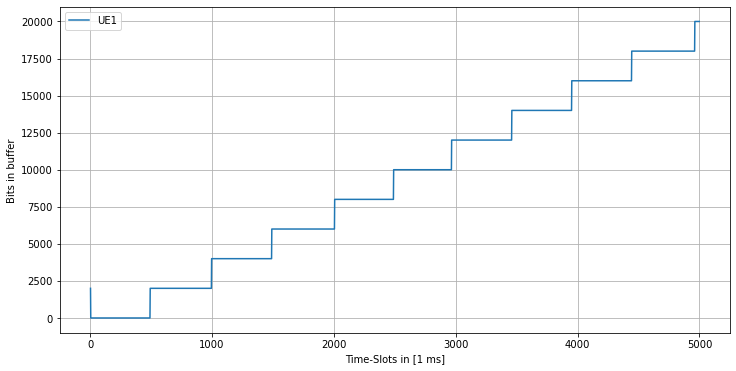

In [69]:
plt.figure(figsize=(12,6))
plt.plot(ue_list[0].mon.keys(),ue_list[0].mon.values(),label='UE1')
#plt.plot(ue_list[1].mon.keys(),ue_list[1].mon.values(),label='UE2')
#plt.plot(ue_list[2].mon.keys(),ue_list[2].mon.values(),label='UE3')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

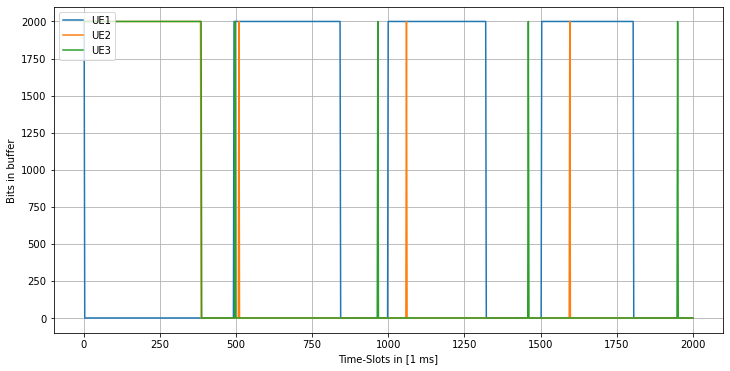

In [67]:
plt.figure(figsize=(12,6))
plt.plot(list(ue_list[0].mon.keys())[:1000],list(ue_list[0].mon.values())[:1000],label='UE1')
plt.plot(list(ue_list[1].mon.keys())[:1000],list(ue_list[1].mon.values())[:1000],label='UE2')
plt.plot(list(ue_list[2].mon.keys())[:1000],list(ue_list[2].mon.values())[:1000],label='UE3')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

(array([205.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  95.]),
 array([14.61092218, 14.62852571, 14.64612923, 14.66373275, 14.68133627,
        14.69893979, 14.71654331, 14.73414683, 14.75175035, 14.76935387,
        14.78695739]),
 <BarContainer object of 10 artists>)

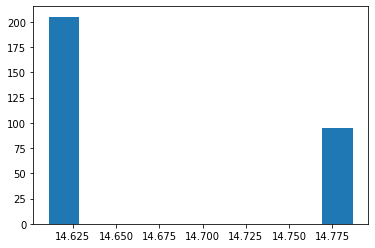

In [57]:
a=np.zeros(300)
for i in np.arange(0,300):
    a[i]=ue_list[i].mR
    
plt.hist(a)